# Pressor Distributions
- Ruoyi Jiang
- July 19, 2019
- Evaluation of the different pressor combinations used in MIMIC

In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(fasttime)

# RR analysis
library(epitools)

# ROC (and plotting)
library(boot)
library(pROC)

# imputation
library(randomForest)

# VIF analysis
library(car)

library(glmnet)
library(pls)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:boot’:

    logit

The following object is masked from ‘package:dplyr’:

    recode

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach
Loaded glmnet 2.0-18


Attaching package: ‘glmnet’

The fo

In [2]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-apple-darwin18.5.0 (64-bit)
Running under: macOS Mojave 10.14.3

Matrix products: default
BLAS/LAPACK: /usr/local/Cellar/openblas/0.3.6_1/lib/libopenblasp-r0.3.6.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] pls_2.7-1           glmnet_2.0-18       foreach_1.4.7      
 [4] Matrix_1.2-17       car_3.0-3           carData_3.0-2      
 [7] randomForest_4.6-14 pROC_1.15.3         boot_1.3-22        
[10] epitools_0.5-10     fasttime_1.0-2      ggplot2_3.2.0      
[13] tidyr_0.8.3         dplyr_0.8.1        

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3      tidyselect_0.2.5  repr_1.0.1        purrr_0.3.2      
 [5] haven_2.1.1       lattice_0.20-38   colorspace_1.4-1  vctrs_0.2.0      
 [9] htmltools_0.3.6   base64enc_0.1-3   rlang_0.4.0       pillar_1.4.0     
[13] f

In [3]:
### Plotting base_theme
base_theme <- function(){ theme_bw() + 
            theme(text=element_text(size=8)) +
            theme(plot.title=element_text(size=8)) +
            theme(plot.background=element_blank(),
                  panel.grid.major=element_blank(), 
                  panel.grid.minor=element_blank()) +
            theme(strip.background=element_blank(),
                  strip.text=element_text(size=7, face='bold')) +
            theme(axis.title=element_text(size=8, vjust=0.25),
                  axis.text.x=element_text(size=8, vjust=0.5, hjust=0.5),
                  axis.text.y=element_text(size=8)) +
            theme(legend.text=element_text(size=7),
                  legend.title=element_text(size=7),
                  legend.key.height=grid::unit(10, "points"), 
                  legend.key.width=grid::unit(10, "points"))}

### Load data and take quick peek at select "pressors"  (e.g. vent and central line)

In [4]:
pressors_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/pressors.csv')

In [5]:
dim(pressors_df)

[1] 227645     11

In [6]:
pressors_df %>%
    filter(pressor == "central_line_durations") %>% head()

X,level_0,level_1,duration_hours,endtime,icustay_id,num,pressor,starttime,vasonum,ventnum
<int>,<fct>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
30584,central_line_durations,0,70.91667,2181-11-28 20:59:00,200001,NA,central_line_durations,2181-11-25 22:04:00,NA,NA
30585,central_line_durations,1,134.00000,2199-08-08 15:00:00,200003,NA,central_line_durations,2199-08-03 01:00:00,NA,NA
30586,central_line_durations,2,37.75000,2189-12-02 08:00:00,200009,NA,central_line_durations,2189-11-30 18:15:00,NA,NA
30587,central_line_durations,3,19.68333,2132-08-05 20:36:00,200010,NA,central_line_durations,2132-08-05 00:55:00,NA,NA
30588,central_line_durations,4,23.76667,2114-12-27 22:46:00,200021,NA,central_line_durations,2114-12-26 23:00:00,NA,NA
30589,central_line_durations,5,9.30000,2127-03-04 01:18:00,200024,NA,central_line_durations,2127-03-03 16:00:00,NA,NA


In [7]:
pressors_df %>%
    filter(pressor == "ventdurations") %>% head()

X,level_0,level_1,duration_hours,endtime,icustay_id,num,pressor,starttime,vasonum,ventnum
<int>,<fct>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
189130,ventdurations,0,91.00000,2199-08-07 13:00:00,200003,NA,ventdurations,2199-08-03 18:00:00,NA,1
189131,ventdurations,1,14.83333,2159-09-04 03:50:00,200006,NA,ventdurations,2159-09-03 13:00:00,NA,1
189132,ventdurations,2,15.83333,2189-12-01 10:00:00,200009,NA,ventdurations,2189-11-30 18:10:00,NA,1
189133,ventdurations,3,3.00000,2188-08-06 04:00:00,200011,NA,ventdurations,2188-08-06 01:00:00,NA,1
189134,ventdurations,4,18.75000,2105-02-17 18:00:00,200014,NA,ventdurations,2105-02-16 23:15:00,NA,1
189135,ventdurations,5,83.00000,2138-03-21 09:00:00,200017,NA,ventdurations,2138-03-17 22:00:00,NA,1


In [8]:
pressors_df %>%
    group_by(pressor) %>%
    summarize(COUNT = n())

pressor,COUNT
<fct>,<int>
adenosinedurations,160
arterial_line_durations,30424
central_line_durations,38211
crrtdurations,5918
dobutaminedurations,1792
dopaminedurations,6524
epinephrinedurations,3126
isupreldurations,24
milrinonedurations,3600


### Available pressor (and other infusions) choices
- Make choices
- Quick check of dataset balancing

In [7]:
pressor_choices <- c("norepinephrinedurations", "dopaminedurations", 
                     "phenylephrinedurations", "vasopressindurations", 'epinephrinedurations', 'dobutaminedurations')

In [8]:
FANCY_PRESSOR_ORDER <- c("Norepinephrine", "Dopamine", "Phenylephrine", "Vasopressin", "Epinephrine", "Dobutamine")

In [9]:
FANCY_PRESSOR_DICT <- c(
'dopaminedurations' = 'Dopamine',
'norepinephrinedurations' = 'Norepinephrine',  
'phenylephrinedurations' = 'Phenylephrine',
"vasopressindurations" = "Vasopressin",
'epinephrinedurations' = "Epinephrine",
'dobutaminedurations' = "Dobutamine"
)

In [10]:
PLOT_DIR <- "~/Google Drive/vasopressors/figures_v3"

In [11]:
pressors_df %>%
    filter(pressor %in% pressor_choices)  %>%
    filter((pressor == 'phenylephrinedurations' & duration_hours > 0.5) |
           (pressor == 'epinephrinedurations' & duration_hours > 0.5) |
           !(pressor %in% c('phenylephrinedurations', 'phenylephrinedurations'))
          ) %>%
    mutate(MORETHAN24HOURS = duration_hours > 24) %>%
    group_by(MORETHAN24HOURS, pressor) %>% 
    summarize(COUNT = n())

MORETHAN24HOURS,pressor,COUNT
<lgl>,<fct>,<int>
FALSE,dobutaminedurations,1412
FALSE,dopaminedurations,5422
FALSE,epinephrinedurations,2797
FALSE,norepinephrinedurations,19811
FALSE,phenylephrinedurations,26872
FALSE,vasopressindurations,2537
TRUE,dobutaminedurations,380
TRUE,dopaminedurations,1102
TRUE,epinephrinedurations,329


### Join with icustay metadata (pressors_df + lengthstay_df -> input_df)
### Also remove <0.5 hr epinephrine and phenyelphrine doses

In [12]:
lengthstay_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/length_stay.csv') %>%
    rename(icustarttime = START, icuendtime = END)

In [13]:
lengthstay_df %>% head()

X,icustay_id,icustarttime,icuendtime,DIFF
<int>,<int>,<fct>,<fct>,<dbl>
1,200001,2181-11-25 19:06:00,2181-11-28 20:00:00,72.90000
2,200003,2199-08-02 19:15:00,2199-08-08 15:00:00,139.75000
3,200006,2159-09-03 12:30:00,2159-09-04 17:00:00,28.50000
4,200007,2109-02-17 09:00:00,2109-02-18 09:15:00,24.25000
5,200009,2189-11-30 11:43:00,2189-12-02 13:00:00,49.28333
6,200010,2132-08-05 00:39:00,2132-08-05 21:17:00,20.63333


In [14]:
# filter by pressor and left join with lengthstay_df
input_df <- pressors_df %>%
    filter(pressor %in% pressor_choices)  %>%
    filter((pressor == 'phenylephrinedurations' & duration_hours > 0.5) |
           (pressor == 'epinephrinedurations' & duration_hours > 0.5) |
           !(pressor %in% c('phenylephrinedurations', 'epinephrinedurations'))
          ) %>%
    left_join(lengthstay_df, by = "icustay_id") %>%
    mutate(starttime = fastPOSIXct(starttime), endtime = fastPOSIXct(endtime), 
           icustarttime = fastPOSIXct(icustarttime), icuendtime = fastPOSIXct(icuendtime))

# Filters

#### Collapse pressor courses based on length of intervening time (<24 hrs)
- Any two courses with less than intervening 24 hours will be collapsed into a single course within an icustay

In [15]:
max_intervening_hrs <- 24

# find the intervening time between courses (endtime of next course - endtime of course - duration of course)
# then determine if that length of time is >24 or <24 and mark it with a 0 if true, else a 1
# use a cumsum to create a new id separating courses that are separated by more than >24

input_df <- input_df %>%
        group_by(icustay_id) %>%
        arrange(starttime) %>%
        mutate(intervening_hours = difftime(endtime, lag(endtime), units="hours") - duration_hours) %>%
        rowwise() %>%
        mutate(increasing = if(intervening_hours < max_intervening_hrs | is.na(intervening_hours)){0}else(1)) %>%
        ungroup() %>%
        group_by(icustay_id) %>%
        mutate(continuous_course = cumsum(increasing)) %>% select(-intervening_hours, -increasing)

In [194]:
# max_intervening_hrs <- 24

# # find the intervening time between courses (endtime of next course - endtime of course - duration of course)
# # then determine if that length of time is >24 or <24 and mark it with a 0 if true, else a 1
# # use a cumsum to create a new id separating courses that are separated by more than >24
# input_list <- list()
# for(pressor_choice in pressor_choices){
#     input_list[[pressor_choice]] <- input_df %>%
#         filter(pressor == pressor_choice) %>%
#         group_by(icustay_id) %>%
#         mutate(intervening_hours = difftime(endtime, lag(endtime), units="hours") - duration_hours) %>%
#         rowwise() %>%
#         mutate(increasing = if(intervening_hours < max_intervening_hrs | is.na(intervening_hours)){0}else(1)) %>%
#         ungroup() %>%
#         group_by(icustay_id) %>%
#         mutate(continuous_course = cumsum(increasing)) %>% select(-intervening_hours, -increasing)
#     cat(pressor_choice, '\n')
# }

In [195]:
# input_df <- bind_rows(input_list, .id="pressor_choice")

- the combination of **continuous course** and **icustay_id** (e.g. 200024, 0 for first row) now defines each pressor course

- assign boolean assessments after <24 hour intervals between pressors are removed
    1. more or less than 24 hours of pressor duration?
    2. is this the first pressor course?
    3. are pressors administered <1 hr of the icustay?

In [16]:
# 1. more or less than 24 hours?
input_df <- input_df %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(MORETHAN24HOURS = sum(duration_hours) > 24, 
           STATUS = if(sum(duration_hours) > 24){"MORETHAN24HOURS"}
           else if(sum(duration_hours) <= 24 & sum(duration_hours) > 6){"LESSTHAN24HOURS"}
           else if(sum(duration_hours) <= 6){"LESSTHAN6HOURS"}
               )

In [17]:
# 2. first pressor course? (groupby icustay, filter min starttime == starttime)
input_df <- input_df %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(coursestarttime = min(starttime)) %>%
    group_by(icustay_id) %>%
    mutate(FIRSTCOURSE = min(coursestarttime) == coursestarttime)

In [18]:
# 3. pressors within 1 hr of icustay_id? (groupby icustay, filter max starttime - unique icustarttime > 1)
input_df <- input_df %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(coursestarttime = min(starttime)) %>%
    group_by(icustay_id) %>%
    mutate(LESS1HOUR = difftime(min(coursestarttime), 
                         min(icustarttime)) < 1)

In [199]:
# grouped by icustay_id + continuous_course + separate_course
input_df %>%
    group_by(LESS1HOUR, FIRSTCOURSE, MORETHAN24HOURS) %>%
    summarize(COUNT = n())

LESS1HOUR,FIRSTCOURSE,MORETHAN24HOURS,COUNT
<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,2217
FALSE,FALSE,TRUE,7872
FALSE,TRUE,FALSE,14401
FALSE,TRUE,TRUE,37122
TRUE,FALSE,FALSE,111
TRUE,FALSE,TRUE,284
TRUE,TRUE,FALSE,891
TRUE,TRUE,TRUE,2010
NA,FALSE,FALSE,151


In [200]:
# With filters grouped by icustay_id + continuous_course
input_df %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(LESS1HOUR, FIRSTCOURSE, MORETHAN24HOURS) %>%
    summarize(COUNT = length(unique(course_id)))

LESS1HOUR,FIRSTCOURSE,MORETHAN24HOURS,COUNT
<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,1392
FALSE,FALSE,TRUE,1356
FALSE,TRUE,FALSE,8623
FALSE,TRUE,TRUE,6768
TRUE,FALSE,FALSE,68
TRUE,FALSE,TRUE,64
TRUE,TRUE,FALSE,580
TRUE,TRUE,TRUE,432
NA,FALSE,FALSE,98


### Introduce other predictor values for each course (like RACE, Diagnosis type) -> nonvitals_predictor_df

In [19]:
races <- c("ASIAN", "BLACK", "HISPANIC", "WHITE", "OTHER")

simplifyRace <- function(ethnicity){
    if(grepl("ASIAN", ethnicity)){return("ASIAN")}
    else if(grepl("BLACK", ethnicity)){return("BLACK")}
    else if(grepl("HISPANIC", ethnicity)){return("HISPANIC")}
    else if(grepl("WHITE", ethnicity)){return("WHITE")}
    else{return("OTHER")}
}

In [20]:
sepsis_regex <- c('SEPSIS', 'SEPTIC', 'CHOLANGITIS', 'UROSEPSIS')

infection_regex <- c('PNEUMONIA', 'INFECTION',  
  'CELULLITIS', 'FASCITIS', 'INFECTED', 'BACTER', 'PNEMONIA', 'ABSCESS', 'NEPHRITIS')

cardiac_regex <- c('HEART', 'CORONARY', 'VENTRICULAR')

simplifyDiagnosis <- function(diagnosis){
    if(any(sapply(sepsis_regex, function(x) grepl(x, diagnosis)))){return("SEPSIS")}
    else if(any(sapply(infection_regex, function(x) grepl(x, diagnosis)))){return("INFECTION")}
    else if(any(sapply(cardiac_regex, function(x) grepl(x, diagnosis)))){return("CARDIAC")}
    else{return("OTHER DIAGNOSIS")}
}

In [21]:
icustays_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/icustays.csv')

In [22]:
admissions_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/admissions.csv')

In [23]:
patients_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/patients.csv')

In [24]:
severity_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/sofa.csv') %>% select(icustay_id, sofa) %>%
    left_join(read.csv('~/Projects/Haimovich_Pressors/collection/out/oasis.csv') %>% select(icustay_id, oasis), by = 'icustay_id') %>%
    left_join(read.csv('~/Projects/Haimovich_Pressors/collection/out/qsofa.csv') %>% select(icustay_id, qsofa), by = 'icustay_id')

In [25]:
intub_df <- pressors_df %>%
    filter(pressor == "ventdurations") 

cvc_df <- pressors_df %>%
    filter(pressor == "central_line_durations") 

In [26]:
# 3 mins
nonvitals_predictor_df <- icustays_df %>%
    select(hadm_id, icustay_id, first_careunit, last_careunit) %>%
    left_join(admissions_df, by = 'hadm_id') %>%
    left_join(patients_df, by = 'subject_id') %>%
    left_join(severity_df, by = 'icustay_id') %>%
    mutate(intub = icustay_id %in% intub_df$icustay_id, cvc = icustay_id %in% cvc_df$icustay_id) %>%
    mutate(deathtime = fastPOSIXct(deathtime), admittime = fastPOSIXct(admittime), dob = fastPOSIXct(dob)) %>%
    mutate(age = difftime(admittime, dob, units="weeks")/52.25, 
           age_cohort = as.numeric(round(age, digits = -1))) %>% 
    rowwise() %>%
    mutate(simple_race = simplifyRace(ethnicity)) %>%
    mutate(simple_diagnosis = simplifyDiagnosis(diagnosis))

### Mortality filter
- Remove patients who stopped using pressors because death (merge with pressors_df by icustay_id, filter if pressor course end time == or is close to deathtime)
- Also quantify some unusual cases of death documentation

In [223]:
#NA means the stay did not end in death
#ICUSTAYS where patient was discharged after death? (TRUE)
nonvitals_predictor_df  %>%
    mutate(MORTALITYERROR = difftime(deathtime, dischtime, units = "mins") < 0) %>%
    group_by(MORTALITYERROR) %>%
    summarize(COUNT = n())

Warning message:
“Grouping rowwise data frame strips rowwise nature”

MORTALITYERROR,COUNT
<lgl>,<int>
FALSE,40
TRUE,6422
NA,55070


In [224]:
#NA means the stay did not end in death
#ICUSTAYS where patient was admitted after death? (TRUE)
nonvitals_predictor_df  %>%
    mutate(MORTALITYERROR = difftime(deathtime, admittime, units = "mins") < 0) %>%
    group_by(MORTALITYERROR) %>%
    summarize(COUNT = n())

Warning message:
“Grouping rowwise data frame strips rowwise nature”

MORTALITYERROR,COUNT
<lgl>,<int>
FALSE,6384
TRUE,78
NA,55070


In [225]:
#Examples (admitted after death)
nonvitals_predictor_df  %>%
    filter(difftime(deathtime, admittime, units = "mins") < 0) %>%
    head(5)

hadm_id,icustay_id,first_careunit,last_careunit,X.x,row_id.x,subject_id,admittime,dischtime,deathtime,⋯,expire_flag,sofa,oasis,qsofa,intub,cvc,age,age_cohort,simple_race,simple_diagnosis
<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<dttm>,<fct>,<dttm>,⋯,<int>,<int>,<int>,<int>,<lgl>,<lgl>,<drtn>,<dbl>,<chr>,<chr>
102631,246694,CSRU,CSRU,456,237,181,2153-10-12 05:49:00,2153-10-12 06:29:00,2153-10-12 02:29:00,⋯,1,2,17,0,FALSE,FALSE,65.12757082 weeks,70,WHITE,OTHER DIAGNOSIS
138015,298263,NICU,NICU,1911,1640,1334,2137-09-02 10:43:00,2137-09-02 12:00:00,2137-09-02 08:00:00,⋯,1,10,24,0,TRUE,FALSE,0.00167654 weeks,0,WHITE,OTHER DIAGNOSIS
181430,291798,SICU,SICU,1970,1699,1381,2189-01-02 09:25:00,2189-01-02 12:00:00,2189-01-02 07:00:00,⋯,1,5,54,2,TRUE,FALSE,81.36049404 weeks,80,WHITE,OTHER DIAGNOSIS
187482,213831,MICU,MICU,693,644,516,2197-07-31 16:18:00,2197-07-31 01:10:00,2197-07-30 21:10:00,⋯,1,2,17,0,FALSE,FALSE,70.88679654 weeks,70,OTHER,OTHER DIAGNOSIS
190088,293048,CCU,CCU,3624,3447,2858,2108-09-25 11:29:00,2108-09-25 12:00:00,2108-09-25 08:00:00,⋯,1,12,50,2,TRUE,FALSE,82.42418356 weeks,80,WHITE,OTHER DIAGNOSIS


In [226]:
# Icustays where patients received pressors after death (TRUE)
input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    mutate(STOPMORTALITY = difftime(deathtime, endtime, units = "mins")) %>% 
    group_by(STOPMORTALITY < 0) %>%
    summarize(COUNT = length(unique(icustay_id)))

STOPMORTALITY < 0,COUNT
<lgl>,<int>
FALSE,3439
TRUE,694
NA,13368


### Test out some mortality filters

In [227]:
### if I do not ignore for unusual cases (pressors after death)
input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course, pressor) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = STOPMORTALITY < 5) %>%
    group_by(STOPMORTALITY) %>%
    summarize(COUNT = n())

STOPMORTALITY,COUNT
<lgl>,<int>
FALSE,18873
TRUE,4427
NA,44964


In [228]:
### if I do ignore these unusual cases
input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course, pressor) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = STOPMORTALITY > 0 &  STOPMORTALITY < 5) %>%
    group_by(STOPMORTALITY) %>%
    summarize(COUNT = n())

STOPMORTALITY,COUNT
<lgl>,<int>
FALSE,23033
TRUE,267
NA,44964


### Create filters for mortality: input_df -> input_death_df

In [38]:
# # ignore NAs (patient did not die), or patient death did not correspond to end of pressor course
# # do not remove unusual cases
# input_death_df <- input_df %>%
#     ungroup() %>%
#     left_join(nonvitals_predictor_df, by = "icustay_id") %>%
#     group_by(icustay_id, continuous_course, pressor) %>%
#     mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
#     mutate(STOPMORTALITY = !(!(STOPMORTALITY < 5) | is.na(STOPMORTALITY)))

In [27]:
# ignore NAs (patient did not die), or patient death did not correspond to end of pressor course
# remove unusual cases
input_death_df <- input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = !(!(STOPMORTALITY > 0 &  STOPMORTALITY < 5) | is.na(STOPMORTALITY)))

### Exclude NICU (all NICU was already excluded by pressor usage): : input_death_df -> input_death_df

In [184]:
input_death_df %>%
    mutate(NICUSTAY = first_careunit == "NICU") %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(LESS1HOUR, FIRSTCOURSE, STOPMORTALITY, MORETHAN24HOURS, NICUSTAY) %>%
    summarize(COUNT = length(unique(course_id)))

LESS1HOUR,FIRSTCOURSE,STOPMORTALITY,MORETHAN24HOURS,NICUSTAY,COUNT
<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,FALSE,FALSE,1384
FALSE,FALSE,FALSE,FALSE,TRUE,7
FALSE,FALSE,FALSE,TRUE,FALSE,1330
FALSE,FALSE,FALSE,TRUE,TRUE,19
FALSE,FALSE,TRUE,FALSE,FALSE,1
FALSE,FALSE,TRUE,TRUE,FALSE,7
FALSE,TRUE,FALSE,FALSE,FALSE,8520
FALSE,TRUE,FALSE,FALSE,TRUE,87
FALSE,TRUE,FALSE,TRUE,FALSE,6636


In [28]:
input_death_df <- input_death_df %>%
    filter(first_careunit != "NICU")

### Use filters, clean predictors: input_death_df -> output_df

In [29]:
output_df <- input_death_df %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(course_id) %>%
    mutate(starttime = min(starttime), endtime = max(endtime)) %>%
    filter(!LESS1HOUR, FIRSTCOURSE, !STOPMORTALITY) 

In [30]:
# collapse so each row is a course_id
output_df <- output_df %>%
    group_by(course_id) %>%
    summarize(
            PATIENT = unique(subject_id)[1],
            STATUS = unique(STATUS)[1], 
            MORETHAN24HOURS = unique(MORETHAN24HOURS)[1], 
            simple_diagnosis = unique(simple_diagnosis)[1], 
            simple_race = unique(simple_race)[1], 
            age = unique(age)[1], 
            age_cohort = unique(age_cohort)[1], 
            cvc = unique(cvc)[1],
            intub = unique(intub)[1],
            first_careunit = unique(first_careunit)[1],
            gender = unique(gender)[1],
            icustay_id = unique(icustay_id)[1],
            starttime = min(starttime), 
            endtime = max(endtime),
            pressor = paste(unique(pressor), collapse=","),
            sofa = unique(sofa)[1],
            qsofa = unique(qsofa)[1],
            oasis = unique(oasis)[1],
    ) %>% 
    mutate(duration = difftime(endtime, 
                       starttime, units="hours"))

### If more than 1 pressor is used, MORETHAN24HOURS is TRUE

In [31]:
output_df <- output_df %>%
    rowwise() %>%
    mutate(RESPONSE = MORETHAN24HOURS | grepl(",", pressor))

### Age filter > 18

In [32]:
output_df <- output_df %>%
    filter(age >= 18 | is.na(age))

# Analysis

### For text, description of meta-data

In [238]:
length(unique(output_df$PATIENT))

[1] 13489

In [33]:
length(unique(output_df$icustay_id))

[1] 15136

In [248]:
length(unique(output_df$course_id))

[1] 15136

In [34]:
# minimum age
min(output_df$age, na.rm=TRUE)

[1] 18.22476

In [240]:
output_df %>%
    mutate(MINOR = age < 18) %>%
    group_by(MINOR, first_careunit) %>%
    summarize(COUNT = n()) 

Warning message:
“Grouping rowwise data frame strips rowwise nature”

MINOR,first_careunit,COUNT
<lgl>,<fct>,<int>
FALSE,CCU,1938
FALSE,CSRU,5755
FALSE,MICU,3818
FALSE,SICU,1738
FALSE,TSICU,1239
NA,CCU,137
NA,CSRU,76
NA,MICU,310
NA,SICU,70


In [241]:
dim(output_df)

[1] 15136    18

In [89]:
output_df %>%
    group_by(STATUS) %>%
    summarize(COUNT = n())

Warning message:
“Grouping rowwise data frame strips rowwise nature”

STATUS,COUNT
<chr>,<int>
LESSTHAN24HOURS,5003
LESSTHAN6HOURS,3509
MORETHAN24HOURS,6624


In [90]:
output_df %>%
    group_by(STATUS, pressor) %>%
    summarize(COUNT = length(unique(PATIENT))) %>%
    filter(!grepl(",", pressor))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

STATUS,pressor,COUNT
<chr>,<chr>,<int>
LESSTHAN24HOURS,dobutaminedurations,57
LESSTHAN24HOURS,dopaminedurations,388
LESSTHAN24HOURS,epinephrinedurations,115
LESSTHAN24HOURS,norepinephrinedurations,916
LESSTHAN24HOURS,phenylephrinedurations,2372
LESSTHAN24HOURS,vasopressindurations,18
LESSTHAN6HOURS,dobutaminedurations,37
LESSTHAN6HOURS,dopaminedurations,407
LESSTHAN6HOURS,epinephrinedurations,71


In [91]:
output_df %>%
    group_by(RESPONSE = STATUS == "LESSTHAN6HOURS" & !grepl(",", pressor)) %>%
    summarize(COUNT =n()) %>% 
    mutate(FREQ = COUNT/sum(COUNT))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,COUNT,FREQ
<lgl>,<int>,<dbl>
FALSE,11838,0.7821089
TRUE,3298,0.2178911


In [92]:
output_df %>%
    group_by(RESPONSE = STATUS == "LESSTHAN6HOURS" & !grepl(",", pressor), cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>%
    filter(RESPONSE)

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
TRUE,FALSE,755,0.2289266
TRUE,TRUE,2543,0.7710734


In [93]:
# Less than 24 hours AND only one vasopressor
output_df %>%
    group_by(RESPONSE = STATUS != "MORETHAN24HOURS" & !grepl(",", pressor)) %>%
    summarize(COUNT = n()) %>% 
    mutate(FREQ = COUNT/sum(COUNT))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,COUNT,FREQ
<lgl>,<int>,<dbl>
FALSE,7916,0.5229915
TRUE,7220,0.4770085


In [94]:
output_df %>%
    group_by(RESPONSE = STATUS != "MORETHAN24HOURS" & !grepl(",", pressor), cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>%
    filter(RESPONSE)

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
TRUE,FALSE,1583,0.2192521
TRUE,TRUE,5637,0.7807479


In [95]:
output_df %>%
    group_by(RESPONSE = STATUS == "MORETHAN24HOURS", cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>%
    filter(RESPONSE)

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
TRUE,FALSE,547,0.0825785
TRUE,TRUE,6077,0.9174215


In [96]:
output_df %>%
    group_by(RESPONSE = grepl(",", pressor), cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>%
    filter(RESPONSE)

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
TRUE,FALSE,459,0.09040772
TRUE,TRUE,4618,0.90959228


#### All courses

Warning message:
“Removed 898 rows containing non-finite values (stat_density).”

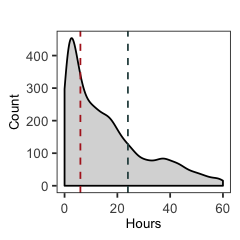

In [92]:
options(repr.plot.width=2, repr.plot.height=2)
p <- output_df %>%
    filter(!grepl(',', pressor)) %>%
    ggplot(aes(x=duration)) +
        base_theme() +
        #geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(aes(y = ..count..), alpha=0.6, fill="gray")+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="",x="Hours", y = "Count")+
        xlim(0, 60) +
        geom_vline(xintercept = 6, linetype= "dashed", color="firebrick") +
        geom_vline(xintercept = 24, linetype= "dashed", color="#2F4F4F")
plot(p)

In [93]:
pdf(file.path(PLOT_DIR, "histo_durations.pdf"), 2, 2)
plot(p)
dev.off()

Warning message:
“Removed 898 rows containing non-finite values (stat_density).”

pdf 
  2

#### Courses involving any of these pressors

Warning message:
“Removed 898 rows containing non-finite values (stat_density).”

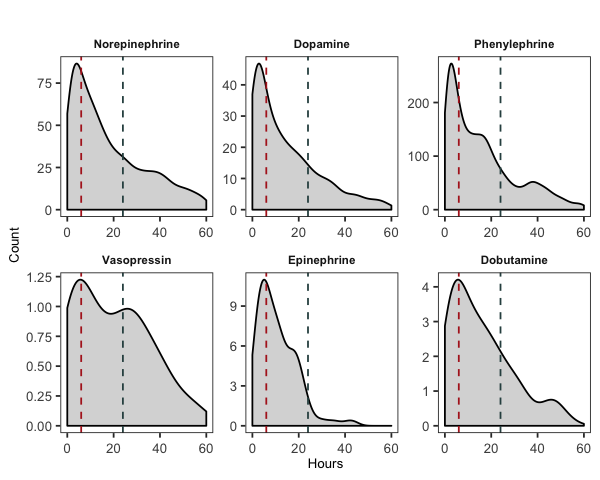

In [96]:
options(repr.plot.width=5, repr.plot.height=4)
p <- output_df %>%
    filter(!grepl(',', pressor)) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=duration)) +
        base_theme() +
        #geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(aes(y = ..count..), alpha=0.6, fill="gray")+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="",x="Hours", y = "Count")+
        xlim(0, 60) +
        geom_vline(xintercept = 6, linetype= "dashed", color="firebrick") +
        geom_vline(xintercept = 24, linetype= "dashed", color="#2F4F4F") +
        facet_wrap(. ~fancy_pressor, nrow=2, ncol=3, scale = "free")
plot(p)

In [97]:
pdf(file.path(PLOT_DIR, "histo_individual_durations.pdf"), 5, 4)
plot(p)
dev.off()

Warning message:
“Removed 898 rows containing non-finite values (stat_density).”

pdf 
  2

### Figure X. CVC associated with longer pressor courses

In [101]:
CVC_COLORS <- c(
"CVC" = '#2F4F4F',
"No CVC" = '#D3D3D3'
)

In [102]:
# <6 hour course
output_df %>%
    filter(!grepl(",", pressor)) %>%
    group_by(RESPONSE = STATUS == "LESSTHAN6HOURS", cvc) %>%
    summarize(COUNT = n(), DURATION = mean(duration)) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,DURATION,FREQ
<lgl>,<lgl>,<int>,<drtn>,<dbl>
FALSE,FALSE,1122,23.076857 hours,0.1659518
FALSE,TRUE,5639,37.483732 hours,0.8340482
TRUE,FALSE,755,2.964062 hours,0.2289266
TRUE,TRUE,2543,3.384297 hours,0.7710734


In [103]:
output_df %>%
    group_by(RESPONSE = STATUS == "MORETHAN24HOURS", cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,1789,0.2101739
FALSE,TRUE,6723,0.7898261
TRUE,FALSE,547,0.0825785
TRUE,TRUE,6077,0.9174215


In [104]:
output_df %>%
    group_by(RESPONSE = grepl(",", pressor), cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,1877,0.18659907
FALSE,TRUE,8182,0.81340093
TRUE,FALSE,459,0.09040772
TRUE,TRUE,4618,0.90959228


In [105]:
pairwise.wilcox.test(as.numeric(output_df$duration), output_df$cvc)


	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(output_df$duration) and output_df$cvc 

     FALSE 
TRUE <2e-16

P value adjustment method: holm 

Warning message:
“Removed 2064 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 2064 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2064 rows containing non-finite values (stat_summary).”

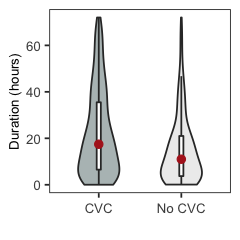

In [106]:
options(repr.plot.width=2, repr.plot.height=2)
p <- output_df %>%
    rowwise() %>%
    mutate(cvc_fancy = if(cvc){"CVC"}else{"No CVC"}) %>%
    mutate(cvc_fancy = factor(cvc_fancy, levels = names(CVC_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=cvc_fancy, y=duration)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Duration (hours)") +
        geom_violin(aes(fill=cvc_fancy), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,72)) +
        geom_boxplot(width=0.05, outlier.shape = NA)+
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick")
        #+ facet_grid(. ~fancy_pressor)
plot(p)

In [107]:
pdf(file.path(PLOT_DIR, "cvcduration.pdf"), 2,2)
plot(p)
dev.off()

Warning message:
“Removed 2064 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 2064 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2064 rows containing non-finite values (stat_summary).”

pdf 
  2

In [108]:
for(presor_choice in pressor_choices){
    pairwise.wilcox.test(as.numeric(filter(output_df,pressor==pressor_choice)$duration), 
                     filter(output_df,pressor==pressor_choice)$cvc) %>% 
    print()
}

ERROR: Error: object 'pressor_choice' not found


Warning message:
“Removed 637 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 637 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 637 rows containing non-finite values (stat_summary).”

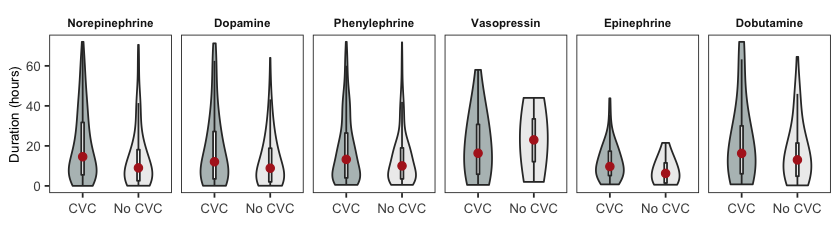

In [109]:
options(repr.plot.width=7, repr.plot.height=2)
p <- output_df %>%
    filter(!grepl(",", pressor)) %>%
    rowwise() %>%
    mutate(cvc_fancy = if(cvc){"CVC"}else{"No CVC"}) %>%
    mutate(cvc_fancy = factor(cvc_fancy, levels = names(CVC_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=cvc_fancy, y=duration)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Duration (hours)") +
        geom_violin(aes(fill=cvc_fancy), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,72)) +
        geom_boxplot(width=0.05, outlier.shape = NA) +
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick") +
        facet_grid(. ~fancy_pressor)
plot(p)

In [110]:
pdf(file.path(PLOT_DIR, "cvcduration_eachpressor.pdf"), 4,2)
plot(p)
dev.off()

Warning message:
“Removed 637 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 637 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 637 rows containing non-finite values (stat_summary).”

pdf 
  2

### Table 1 Demographics

In [82]:
t1_df <- output_df %>% 
    group_by(STATUS) %>%
    summarize(n = paste(round(as.numeric(n()),2), paste0('(', 100*(n()/nrow(output_df)) %>% round(3), '%)')), 
            Age = paste(round(as.numeric(mean(age, na.rm=TRUE)),2), paste0('(SD=', sd(age, na.rm=TRUE) %>% round(2),')')), 
            Male = paste(sum(gender == 'M'), paste0('(',100*round(sum(gender == 'M')/n(),3),'%)')),
            MICU = paste(sum(first_careunit == 'MICU'), paste0('(',100*round(sum(first_careunit == 'MICU')/n(),3),'%)')),
            SICU = paste(sum(first_careunit == 'SICU'), paste0('(',100*round(sum(first_careunit == 'SICU')/n(),3),'%)')),
            CCU = paste(sum(first_careunit == 'CCU'), paste0('(',100*round(sum(first_careunit == 'CCU')/n(),3),'%)')),
            TSICU = paste(sum(first_careunit == 'TSICU'), paste0('(',100*round(sum(first_careunit == 'TSICU')/n(),3),'%)')),
            CSRU = paste(sum(first_careunit == 'CSRU'), paste0('(',100*round(sum(first_careunit == 'CSRU')/n(),3),'%)')),
            Sepsis = paste(sum(simple_diagnosis == "SEPSIS"), paste0('(',100*round(sum(simple_diagnosis == "SEPSIS")/n(),3),'%)')),
            Infectious = paste(sum(simple_diagnosis == "INFECTION"), paste0('(',100*round(sum(simple_diagnosis == "INFECTION")/n(),3),'%)')),
            Cardiac = paste(sum(simple_diagnosis == "CARDIAC"), paste0('(',100*round(sum(simple_diagnosis == "CARDIAC")/n(),3),'%)')),
            CVC = paste(sum(cvc == "TRUE"), paste0('(',100*round(sum(cvc == "TRUE")/n(),3),'%)')),
            Intubated = paste(sum(intub == "TRUE"), paste0('(',100*round(sum(intub == "TRUE")/n(),3),'%)'))
             ) %>% t()

Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [83]:
colnames(t1_df) <- t1_df[1,]

In [84]:
t1_df

,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
STATUS,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
n,5003 (33.1%),3509 (23.2%),6624 (43.8%)
Age,65.58 (SD=13.83),66.22 (SD=13.84),65.8 (SD=14.13)
Male,3067 (61.3%),2079 (59.2%),3907 (59%)
MICU,1250 (25%),785 (22.4%),2093 (31.6%)
SICU,571 (11.4%),392 (11.2%),845 (12.8%)
CCU,644 (12.9%),455 (13%),976 (14.7%)
TSICU,420 (8.4%),292 (8.3%),582 (8.8%)
CSRU,2118 (42.3%),1585 (45.2%),2128 (32.1%)
Sepsis,333 (6.7%),150 (4.3%),520 (7.9%)


In [85]:
t1_multi_df <- output_df %>% 
    rowwise() %>%
    mutate(MULTI = if(grepl(",", pressor)){'MULTI'}else{'NOT MULTI'}) %>%
    group_by(MULTI) %>%
        summarize(n = paste(round(as.numeric(n()),2), paste0('(', 100*(n()/nrow(output_df)) %>% round(3), '%)')), 
            Age = paste(round(as.numeric(mean(age, na.rm=TRUE)),2), paste0('(SD=', sd(age, na.rm=TRUE) %>% round(2),')')), 
            Male = paste(sum(gender == 'M'), paste0('(',100*round(sum(gender == 'M')/n(),3),'%)')),
            MICU = paste(sum(first_careunit == 'MICU'), paste0('(',100*round(sum(first_careunit == 'MICU')/n(),3),'%)')),
            SICU = paste(sum(first_careunit == 'SICU'), paste0('(',100*round(sum(first_careunit == 'SICU')/n(),3),'%)')),
            CCU = paste(sum(first_careunit == 'CCU'), paste0('(',100*round(sum(first_careunit == 'CCU')/n(),3),'%)')),
            TSICU = paste(sum(first_careunit == 'TSICU'), paste0('(',100*round(sum(first_careunit == 'TSICU')/n(),3),'%)')),
            CSRU = paste(sum(first_careunit == 'CSRU'), paste0('(',100*round(sum(first_careunit == 'CSRU')/n(),3),'%)')),
            Sepsis = paste(sum(simple_diagnosis == "SEPSIS"), paste0('(',100*round(sum(simple_diagnosis == "SEPSIS")/n(),3),'%)')),
            Infectious = paste(sum(simple_diagnosis == "INFECTION"), paste0('(',100*round(sum(simple_diagnosis == "INFECTION")/n(),3),'%)')),
            Cardiac = paste(sum(simple_diagnosis == "CARDIAC"), paste0('(',100*round(sum(simple_diagnosis == "CARDIAC")/n(),3),'%)')),
            CVC = paste(sum(cvc == "TRUE"), paste0('(',100*round(sum(cvc == "TRUE")/n(),3),'%)')),
            Intubated = paste(sum(intub == "TRUE"), paste0('(',100*round(sum(intub == "TRUE")/n(),3),'%)'))
             ) %>% t()

Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [86]:
colnames(t1_multi_df) <- t1_multi_df[1,]

In [87]:
t1_multi_df

,MULTI,NOT MULTI
MULTI,MULTI,NOT MULTI
n,5077 (33.5%),10059 (66.5%)
Age,66.44 (SD=14.14),65.51 (SD=13.86)
Male,3010 (59.3%),6043 (60.1%)
MICU,1632 (32.1%),2496 (24.8%)
SICU,558 (11%),1250 (12.4%)
CCU,798 (15.7%),1277 (12.7%)
TSICU,387 (7.6%),907 (9%)
CSRU,1702 (33.5%),4129 (41%)
Sepsis,409 (8.1%),594 (5.9%)


In [88]:
cbind(t1_df, t1_multi_df) %>% write.csv(file.path(PLOT_DIR, "response_demographics.csv"))

### Supplement Table (solo agents)

In [89]:
s1_3_df <- output_df %>% 
    filter(!grepl(",", pressor)) %>%
    group_by(STATUS, pressor) %>%
        summarize(n = paste(round(as.numeric(n()),2), paste0('(', 100*(n()/nrow(output_df)) %>% round(3), '%)')), 
            Age = paste(round(as.numeric(mean(age, na.rm=TRUE)),2), paste0('(SD=', sd(age, na.rm=TRUE) %>% round(2),')')), 
            Male = paste(sum(gender == 'M'), paste0('(',100*round(sum(gender == 'M')/n(),3),'%)')),
            MICU = paste(sum(first_careunit == 'MICU'), paste0('(',100*round(sum(first_careunit == 'MICU')/n(),3),'%)')),
            SICU = paste(sum(first_careunit == 'SICU'), paste0('(',100*round(sum(first_careunit == 'SICU')/n(),3),'%)')),
            CCU = paste(sum(first_careunit == 'CCU'), paste0('(',100*round(sum(first_careunit == 'CCU')/n(),3),'%)')),
            TSICU = paste(sum(first_careunit == 'TSICU'), paste0('(',100*round(sum(first_careunit == 'TSICU')/n(),3),'%)')),
            CSRU = paste(sum(first_careunit == 'CSRU'), paste0('(',100*round(sum(first_careunit == 'CSRU')/n(),3),'%)')),
            Sepsis = paste(sum(simple_diagnosis == "SEPSIS"), paste0('(',100*round(sum(simple_diagnosis == "SEPSIS")/n(),3),'%)')),
            Infectious = paste(sum(simple_diagnosis == "INFECTION"), paste0('(',100*round(sum(simple_diagnosis == "INFECTION")/n(),3),'%)')),
            Cardiac = paste(sum(simple_diagnosis == "CARDIAC"), paste0('(',100*round(sum(simple_diagnosis == "CARDIAC")/n(),3),'%)')),
            CVC = paste(sum(cvc == "TRUE"), paste0('(',100*round(sum(cvc == "TRUE")/n(),3),'%)')),
            Intubated = paste(sum(intub == "TRUE"), paste0('(',100*round(sum(intub == "TRUE")/n(),3),'%)'))
             )

Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [90]:
s1_3_df <- output_df %>% 
    filter(!grepl(",", pressor)) %>%
    group_by(STATUS, pressor) %>%
        summarize(n = n(), 
            Age = paste(round(as.numeric(mean(age, na.rm=TRUE)),2), paste0('(SD=', sd(age, na.rm=TRUE) %>% round(2),')')), 
            Male = paste(sum(gender == 'M'), paste0('(',100*round(sum(gender == 'M')/n(),3),'%)')),
            MICU = paste(sum(first_careunit == 'MICU'), paste0('(',100*round(sum(first_careunit == 'MICU')/n(),3),'%)')),
            SICU = paste(sum(first_careunit == 'SICU'), paste0('(',100*round(sum(first_careunit == 'SICU')/n(),3),'%)')),
            CCU = paste(sum(first_careunit == 'CCU'), paste0('(',100*round(sum(first_careunit == 'CCU')/n(),3),'%)')),
            TSICU = paste(sum(first_careunit == 'TSICU'), paste0('(',100*round(sum(first_careunit == 'TSICU')/n(),3),'%)')),
            CSRU = paste(sum(first_careunit == 'CSRU'), paste0('(',100*round(sum(first_careunit == 'CSRU')/n(),3),'%)')),
            Sepsis = paste(sum(simple_diagnosis == "SEPSIS"), paste0('(',100*round(sum(simple_diagnosis == "SEPSIS")/n(),3),'%)')),
            Infectious = paste(sum(simple_diagnosis == "INFECTION"), paste0('(',100*round(sum(simple_diagnosis == "INFECTION")/n(),3),'%)')),
            Cardiac = paste(sum(simple_diagnosis == "CARDIAC"), paste0('(',100*round(sum(simple_diagnosis == "CARDIAC")/n(),3),'%)')),
            CVC = paste(sum(cvc == "TRUE"), paste0('(',100*round(sum(cvc == "TRUE")/n(),3),'%)')),
            Intubated = paste(sum(intub == "TRUE"), paste0('(',100*round(sum(intub == "TRUE")/n(),3),'%)'))
             )

Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [91]:
for(pressor_choice in pressor_choices){
    out_df <- s1_3_df %>%
        filter(pressor == pressor_choice) %>%
        ungroup() %>%
        mutate(n = paste0(n, ' (', (n/sum(n)) %>% round(3), '%)')) %>%
        t()
    colnames(out_df) <- out_df[1,]
    out_df %>% 
        data.frame() %>%
        select(LESSTHAN6HOURS, LESSTHAN24HOURS, MORETHAN24HOURS) %>%
        write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_demographics.csv")))
}

# Categorical Predictors

In [98]:
# This function, given a dataframe with the appropriate columns, will compute RR statistics and return as a table 
calculatePredictors <- function(df){
    all_rr_list <- list()

    # gender
    output <- df %>%
        group_by(RESPONSE, gender) %>%
        summarize(COUNT = n()) %>%
        spread(RESPONSE, COUNT) %>%
        tibble::column_to_rownames("gender") %>%
        as.matrix() %>% riskratio()

    all_rr_list[['MALE_RR']] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'M') %>%
            mutate(ID = "M", p = output$p.value["M","fisher.exact"])


#     # race
#     rr_list <- list()
#     for(race in races){
#        output <- df %>%
#             rowwise() %>%
#             group_by(RESPONSE, simple_race) %>%
#             summarize(COUNT = n()) %>%
#             mutate(RACE_BOOL = simple_race == race) %>%
#             group_by(RACE_BOOL, RESPONSE) %>%
#             summarize(COUNT = sum(COUNT)) %>%
#             spread(RESPONSE, COUNT) %>%
#             tibble::column_to_rownames("RACE_BOOL") %>%
#             as.matrix() %>% riskratio() 
#         rr_list[[race]] <- output$measure %>%
#             data.frame() %>%
#             tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
#             mutate(ID = race, p = output$p.value["TRUE","fisher.exact"])
#     }


#     all_rr_list[['RACE_RR']] <- bind_rows(rr_list)


    # age
    age_df <- df %>%
        group_by(RESPONSE, age_cohort) %>%
        summarize(COUNT = n()) %>%
        drop_na(age_cohort)

    rr_list <- list()
    for(ac in unique(age_df$age_cohort)){
       if(ac != 0){
           output <- age_df %>%
                mutate(AGE_BOOL = age_cohort == ac) %>%
                group_by(AGE_BOOL, RESPONSE) %>%
                summarize(COUNT = sum(COUNT)) %>%
                spread(RESPONSE, COUNT) %>%
                tibble::column_to_rownames("AGE_BOOL") %>%
                as.matrix() %>% riskratio() 

            rr_list[[ac]] <- output$measure %>%
                data.frame() %>%
                tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
                mutate(ID = as.character(ac), p = output$p.value["TRUE","fisher.exact"])
       }  
    }

    all_rr_list[['AGE_RR']] <- bind_rows(rr_list)


    # diagnosis
    diagnosis_df <- df %>%
        rowwise() %>%
        group_by(simple_diagnosis, RESPONSE) %>%
        summarize(COUNT = n()) 

    rr_list <- list()
    for(s_d in unique(diagnosis_df$simple_diagnosis)){
       output <- diagnosis_df %>%
            mutate(DX_BOOL = simple_diagnosis == s_d) %>%
            group_by(DX_BOOL, RESPONSE) %>%
            summarize(COUNT = sum(COUNT)) %>%
            spread(RESPONSE, COUNT) %>%
            tibble::column_to_rownames("DX_BOOL") %>%
            as.matrix() %>% riskratio() 
        rr_list[[s_d]] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = s_d, p = output$p.value["TRUE","fisher.exact"])
    }

    all_rr_list[['DIAGNOSIS_RR']] <- bind_rows(rr_list)


    # careunit
    careunit_df <- df %>%
        group_by(RESPONSE, first_careunit) %>%
        summarize(COUNT = n())

    rr_list <- list()
    for(cu in unique(careunit_df$first_careunit)){
       output <- careunit_df%>%
            mutate(CU_BOOL = first_careunit == cu) %>%
            group_by(CU_BOOL, RESPONSE) %>%
            summarize(COUNT = sum(COUNT)) %>%
            spread(RESPONSE, COUNT) %>%
            tibble::column_to_rownames("CU_BOOL") %>%
            as.matrix() %>% riskratio() 
        rr_list[[cu]] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = cu, p = output$p.value["TRUE","fisher.exact"])
    }

    all_rr_list[['CAREUNIT_RR']] <- bind_rows(rr_list)


    # intub
    output <- df %>%
        group_by(RESPONSE, intub) %>%
        summarize(COUNT = n()) %>%
        spread(RESPONSE, COUNT) %>%
        tibble::column_to_rownames("intub") %>%
        as.matrix() %>% riskratio()

    all_rr_list[['INTUB_RR']] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = "INTUB", p = output$p.value["TRUE","fisher.exact"])

#     # cvc
#     output <- df %>%
#         group_by(RESPONSE, cvc) %>%
#         summarize(COUNT = n()) %>%
#         spread(RESPONSE, COUNT) %>%
#         tibble::column_to_rownames("cvc") %>%
#         as.matrix() %>% riskratio()

#     all_rr_list[['CVC_RR']] <- output$measure %>%
#             data.frame() %>%
#             tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
#             mutate(ID = "CVC", p = output$p.value["TRUE","fisher.exact"])


    # combined
    all_rr_df <- bind_rows(all_rr_list, .id="TYPE") %>%
        mutate(significant = p < 0.05)
    
    return(all_rr_df)
}


# Table 1 (RR significance)

In [99]:
rr_df <- calculatePredictors(output_df) %>%
    rowwise() %>%
    mutate(ID = if(ID == "M"){"MALE"}else{ID}) %>% select(-FILTER)
rr_df

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

TYPE,estimate,lower,upper,ID,p,significant
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>
MALE_RR,0.9526903,0.9238489,0.9824321,MALE,2.138664e-03,TRUE
AGE_RR,0.9503516,0.8032454,1.1243988,20,5.515101e-01,FALSE
AGE_RR,1.0399437,0.9371338,1.1540324,30,4.879422e-01,FALSE
AGE_RR,1.0449525,0.9740602,1.1210043,40,2.404807e-01,FALSE
AGE_RR,0.9645564,0.9201279,1.0111301,50,1.290005e-01,FALSE
AGE_RR,0.9742233,0.9379326,1.0119182,60,1.747521e-01,FALSE
AGE_RR,0.9778820,0.9435909,1.0134192,70,2.206118e-01,FALSE
AGE_RR,1.0602263,1.0238492,1.0978959,80,1.247789e-03,TRUE
AGE_RR,0.9884288,0.9199328,1.0620248,90,7.616862e-01,FALSE


In [100]:
rr_df %>% 
    write.csv(file.path(PLOT_DIR, "relativerisk.csv"))

# Continuous Predictors

In [35]:
PRESSORHOURS_DICT <- c(
'TRUE' = "Prolonged or multiple vasopressor",
'FALSE' = "No prolonged or multiple vasopressor"
)

In [36]:
PRESSORHOURS_COLORS <- c(
"Prolonged or multiple vasopressor" = '#2F4F4F',
"No prolonged or multiple vasopressor" = '#D3D3D3'
)

In [121]:
SEPSIS_COLORS <- c(
"Sepsis" = '#2F4F4F',
"Not sepsis" = '#D3D3D3'
)

In [122]:
severity_output_df <- output_df %>%
    rowwise() %>%
    mutate(PRESSORHOURS = PRESSORHOURS_DICT[as.character(RESPONSE)]) %>%
    mutate(SEPSIS = if(simple_diagnosis == "SEPSIS"){"Sepsis"}else("Not sepsis"))

In [123]:
library(ggpubr)

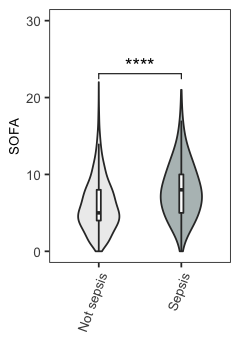

In [124]:
options(repr.plot.width=2, repr.plot.height=3)
p <- severity_output_df %>%
    ggplot(aes(x=SEPSIS, y=sofa)) +
        base_theme() + 
        theme(legend.position="none", axis.text.x=element_text(vjust=1, hjust=1, angle=70)) +
        xlab("") +
        ylab("SOFA") +
        geom_violin(aes(fill=SEPSIS), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=SEPSIS_COLORS) +
        scale_y_continuous(limits=c(0,30)) +
        geom_boxplot(width=0.05, outlier.shape = NA) +
        stat_compare_means(method="wilcox.test", label = "p.signif", comparisons = list(c("Sepsis", "Not sepsis")), size = 4)
        #stat_summary(fun.y=median, geom="point", size=2, color="firebrick")
plot(p)

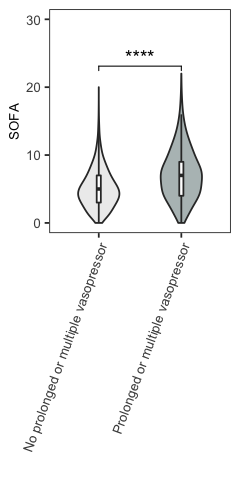

In [50]:
options(repr.plot.width=2, repr.plot.height=4)
p <- severity_output_df %>%
    ggplot(aes(x=PRESSORHOURS, y=sofa)) +
        base_theme() + 
        theme(legend.position="none", axis.text.x=element_text(vjust=1, hjust=1, angle=70)) +
        xlab("") +
        ylab("SOFA") +
        geom_violin(aes(fill=PRESSORHOURS), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=PRESSORHOURS_COLORS) +
        scale_y_continuous(limits=c(0,30)) +
        geom_boxplot(width=0.05, outlier.shape = NA) +
        stat_compare_means(method="wilcox.test", label = "p.signif", comparisons = list(c("Prolonged or multiple vasopressor", "No prolonged or multiple vasopressor")), size = 4)
        #stat_summary(fun.y=median, geom="point", size=2, color="firebrick")
plot(p)

In [ ]:
pdf(file.path(PLOT_DIR, "sofa.pdf"), 2,4)
plot(p)
dev.off()

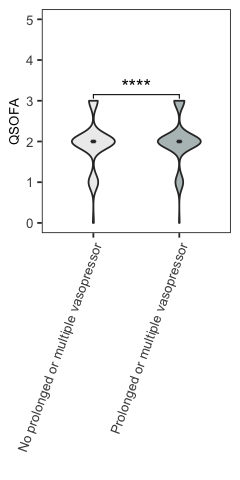

In [52]:
options(repr.plot.width=2, repr.plot.height=4)
p <- severity_output_df %>%
    ggplot(aes(x=PRESSORHOURS, y=qsofa)) +
        base_theme() + 
        theme(legend.position="none", axis.text.x=element_text(vjust=1, hjust=1, angle=70)) +
        xlab("") +
        ylab("QSOFA") +
        geom_violin(aes(fill=PRESSORHOURS), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=PRESSORHOURS_COLORS) +
        scale_y_continuous(limits=c(0,5)) +
        geom_boxplot(width=0.05, outlier.shape = NA) +
        stat_compare_means(method="wilcox.test", label = "p.signif", comparisons = list(c("Prolonged or multiple vasopressor", "No prolonged or multiple vasopressor")), size = 4)
        #stat_summary(fun.y=median, geom="point", size=2, color="firebrick")
plot(p)

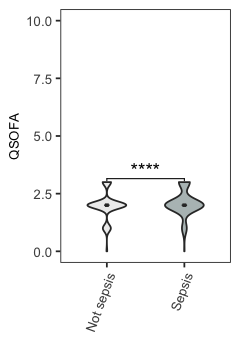

In [126]:
options(repr.plot.width=2, repr.plot.height=3)
p <- severity_output_df %>%
    ggplot(aes(x=SEPSIS, y=qsofa)) +
        base_theme() + 
        theme(legend.position="none", axis.text.x=element_text(vjust=1, hjust=1, angle=70)) +
        xlab("") +
        ylab("QSOFA") +
        geom_violin(aes(fill=SEPSIS), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=SEPSIS_COLORS) +
        scale_y_continuous(limits=c(0,10)) +
        geom_boxplot(width=0.05, outlier.shape = NA) +
        stat_compare_means(method="wilcox.test", label = "p.signif", comparisons = list(c("Sepsis", "Not sepsis")), size = 4)
        #stat_summary(fun.y=median, geom="point", size=2, color="firebrick")
plot(p)

In [ ]:
pdf(file.path(PLOT_DIR, "qsofa.pdf"), 2,4)
plot(p)
dev.off()

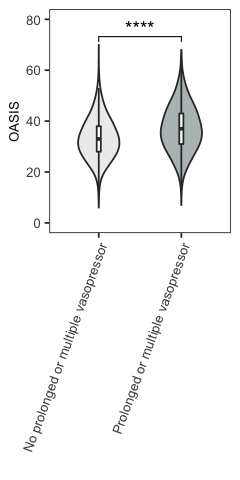

In [53]:
options(repr.plot.width=2, repr.plot.height=4)
p <- severity_output_df %>%
    ggplot(aes(x=PRESSORHOURS, y=oasis)) +
        base_theme() + 
        theme(legend.position="none", axis.text.x=element_text(vjust=1, hjust=1, angle=70)) +
        xlab("") +
        ylab("OASIS") +
        geom_violin(aes(fill=PRESSORHOURS), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=PRESSORHOURS_COLORS) +
        scale_y_continuous(limits=c(0,80)) +
        geom_boxplot(width=0.05, outlier.shape = NA) +
        stat_compare_means(method="wilcox.test", label = "p.signif", comparisons = list(c("Prolonged or multiple vasopressor", "No prolonged or multiple vasopressor")), size = 4)
        #stat_summary(fun.y=median, geom="point", size=2, color="firebrick")
plot(p)

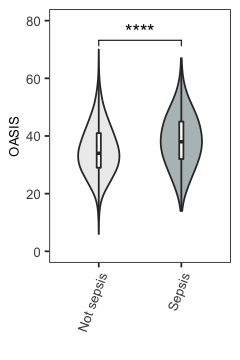

In [129]:
options(repr.plot.width=2, repr.plot.height=3)
p <- severity_output_df %>%
    ggplot(aes(x=SEPSIS, y=oasis)) +
        base_theme() + 
        theme(legend.position="none", axis.text.x=element_text(vjust=1, hjust=1, angle=70)) +
        xlab("") +
        ylab("OASIS") +
        geom_violin(aes(fill=SEPSIS), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=SEPSIS_COLORS) +
        scale_y_continuous(limits=c(0,80)) +
        geom_boxplot(width=0.05, outlier.shape = NA) +
        stat_compare_means(method="wilcox.test", label = "p.signif", comparisons = list(c("Sepsis", "Not sepsis")), size = 4)
        #stat_summary(fun.y=median, geom="point", size=2, color="firebrick")
plot(p)

In [ ]:
pdf(file.path(PLOT_DIR, "oasis.pdf"), 2,4)
plot(p)
dev.off()

### Supplement (single agents)
- Insufficient numbers for RR analysis for epinephrine and vasopressin

In [101]:
pressor_rr_list <- list()
for(pressor_choice in c('norepinephrinedurations', 'dopaminedurations', 'phenylephrinedurations')){
    pressor_rr_list[[pressor_choice]] <- output_df %>%
        filter(grepl(pressor_choice, pressor)) %>%
        calculatePredictors()
}

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message

In [102]:
pressor_rr_df <- bind_rows(pressor_rr_list, .id="pressor")  %>% select(-FILTER)

In [103]:
pressor_rr_df

pressor,TYPE,estimate,lower,upper,ID,p,significant
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>
norepinephrinedurations,MALE_RR,1.0169094,0.9864643,1.0482941,M,2.812881e-01,FALSE
norepinephrinedurations,AGE_RR,0.9313320,0.7889696,1.0993825,20,3.910097e-01,FALSE
norepinephrinedurations,AGE_RR,1.0172188,0.9268047,1.1164532,30,7.797122e-01,FALSE
norepinephrinedurations,AGE_RR,1.0188776,0.9532874,1.0889806,40,6.398994e-01,FALSE
norepinephrinedurations,AGE_RR,1.0072750,0.9640331,1.0524565,50,7.630698e-01,FALSE
norepinephrinedurations,AGE_RR,0.9835992,0.9468824,1.0217397,60,4.033400e-01,FALSE
norepinephrinedurations,AGE_RR,1.0150243,0.9800530,1.0512436,70,4.262796e-01,FALSE
norepinephrinedurations,AGE_RR,1.0043187,0.9699042,1.0399544,80,8.381776e-01,FALSE
norepinephrinedurations,AGE_RR,0.9580776,0.8935936,1.0272149,90,2.062079e-01,FALSE


In [104]:
pressor_rr_df %>% 
    write.csv(file.path(PLOT_DIR, "relativerisk_eachpressor.csv"))

# Figure 1 Plotting RR

In [105]:
SIGNIFICANT_COLORS <- c(
"Significant" = '#2F4F4F',
"Not Significant" = '#D3D3D3'
)

In [106]:
ID_DICT <- c(
'M' = "Male Gender",
'INTUB' = "Intubated",
#'CVC' = "CVC Placed",
'20' = "Age 15-25",
'30' = "Age 25-35",
'40' = "Age 35-45",
'50' = "Age 45-55",
'60' = "Age 55-65",
'70' = "Age 65-75",
'80' = "Age 75-85",
'90' = "Age 85-95",
'CARDIAC' = "Cardiac Diagnosis",
'INFECTION' = "Infectious Diagnosis",
'SEPSIS' = "Sepsis Diagnosis",
'OTHER DIAGNOSIS' = "Other Diagnosis",
'CCU' = 'CCU',
'CSRU' = 'CSRU',
'MICU' = 'MICU',
'SICU' = 'SICU',
'TSICU' = 'TSICU'
)

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

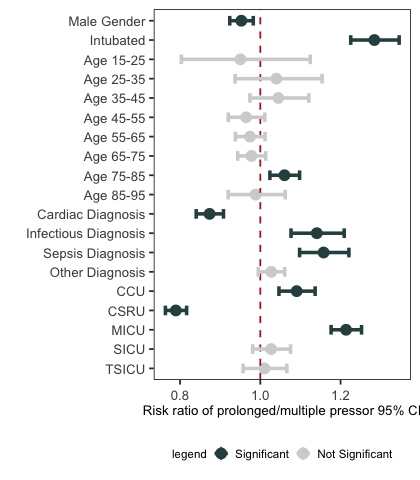

In [116]:
options(repr.plot.width=3.5, repr.plot.height=4)
p <- calculatePredictors(output_df)  %>%
    rowwise() %>%
    mutate(ID = ID_DICT[ID]) %>% 
    mutate(ID = factor(ID, levels=rev(ID_DICT))) %>%
    mutate(significant = if(significant){'Significant'}else{'Not Significant'}) %>%
    mutate(legend = factor(significant, levels=names(SIGNIFICANT_COLORS))) %>%
    ggplot(aes(x = ID,y = estimate, ymin = lower, ymax = upper ))+
        base_theme() +
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Risk ratio of prolonged/multiple pressor 95% CI")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=significant),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [117]:
pdf(file.path(PLOT_DIR, "relativerisk.pdf"), 3.5,4)
plot(p)
dev.off()

pdf 
  2

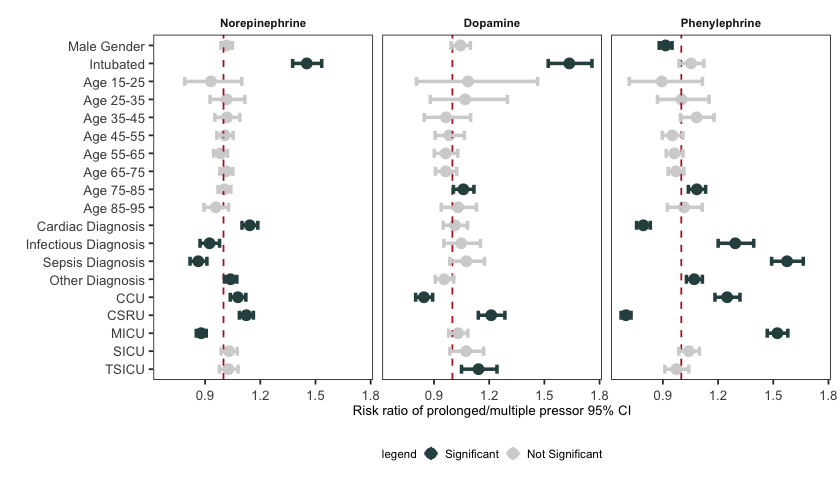

In [118]:
options(repr.plot.width=7, repr.plot.height=4)
p <- pressor_rr_df  %>%
    rowwise() %>%
    mutate(ID = ID_DICT[ID]) %>% 
    mutate(ID = factor(ID, levels=rev(ID_DICT))) %>%
    mutate(significant = if(significant){'Significant'}else{'Not Significant'}) %>%
    mutate(legend = factor(significant, levels=names(SIGNIFICANT_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x = ID,y = estimate, ymin = lower, ymax = upper ))+
        base_theme() +
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Risk ratio of prolonged/multiple pressor 95% CI")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=significant),width=0.5,cex=1)+ 
        coord_flip() + 
        facet_grid(. ~fancy_pressor)
plot(p)

In [119]:
pdf(file.path(PLOT_DIR, "relativerisk_eachpressor.pdf"), 7,4)
plot(p)
dev.off()

pdf 
  2

# Vitals

### Pre-processing (30 minutes): read in vitals_df, join with output_df of courses and compute mean vitals information each hour -> results_df

In [134]:
vitals_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/vitals.csv')

In [135]:
# takes 6 mins to run (because of difftime)

vitals_merged_df <- vitals_df %>%
    mutate(charttime = fastPOSIXct(charttime)) %>%
    filter(icustay_id %in% output_df$icustay_id) %>%
    left_join(select(output_df, icustay_id, course_id, pressor, starttime, endtime, MORETHAN24HOURS, RESPONSE, STATUS), by = "icustay_id") %>%
    rowwise() %>%
    mutate(diff = difftime(charttime, 
                       starttime, units="hours"))

In [136]:
# for 10 hours prior to pressor initiation
intervals <- 1:10

In [137]:
results_list <- list()

In [138]:
# takes 40 mins to run overall
for(interval in intervals){
    # 4 mins to run each
    results_list[[interval]] <- vitals_merged_df %>%
        filter(diff < 0) %>%
        filter(diff < -(interval - 1) & diff > -interval) %>%
        group_by(MORETHAN24HOURS, RESPONSE, STATUS, course_id, pressor) %>%
        summarize(mean_heartrate = mean(heartrate, na.rm=T), 
                  mean_sysbp = mean(sysbp, na.rm=T),
                  mean_diasbp = mean(diasbp, na.rm=T),
                  mean_meanbp = mean(meanbp, na.rm=T), 
                  mean_resprate = mean(resprate, na.rm=T), 
                  mean_tempc = mean(tempc, na.rm=T), 
                  mean_spo2 = mean(spo2, na.rm=T), 
                  mean_glucose = mean(glucose, na.rm=T), 

                  median_heartrate = median(heartrate, na.rm=T), 
                  median_sysbp = median(sysbp, na.rm=T),
                  median_diasbp = median(diasbp, na.rm=T),
                  median_meanbp = median(meanbp, na.rm=T), 
                  median_resprate = median(resprate, na.rm=T), 
                  median_tempc = median(tempc, na.rm=T), 
                  median_spo2 = median(spo2, na.rm=T), 
                  median_glucose = median(glucose, na.rm=T),

                 ) %>%
        mutate(INTERVAL = interval)

}

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [139]:
results_df <- bind_rows(results_list) 

In [140]:
melt_results_df <- results_df %>% 
    gather("ID", "VALUE", -course_id, -pressor, -MORETHAN24HOURS, -INTERVAL, -STATUS, -RESPONSE)

In [141]:
melt_results_df %>% write.csv('~/Projects/Haimovich_Pressors/collection/out/melt_summarized_vitals.csv')

### Read-in directly

In [54]:
melt_results_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/melt_summarized_vitals.csv')


### ANCOVA analysis using intervals
- MORETHAN24HOURS P-value tells you if this vital sign is a predictor (BP, HR, RR, TEMP)
- INTERVAL P-value tells you if these values change depending on the interval being measured (most values)
- MORETHAN24HOURS:INTERVAL P-value tells you if vital sign interacts with the interval being measured, that is, the extent of predictive value differs with time (BP especially, others are borderline significant)

In [138]:
computeANCOVA <- function(df) {
    vitals_result_list <- list()
    for(vital in unique(melt_results_df$ID)){
        #cat("####", vital, "####")
        totest <- df %>%
             filter(ID == vital)
        test <- summary(aov(VALUE ~ RESPONSE*INTERVAL, data = totest))[[1]]

        vitals_result_list[[vital]] <- data.frame(RESPONSE = test["RESPONSE", "Pr(>F)"],
                                                RESPONSE_F = test["RESPONSE", "F value"],
                                                 INTERACTION = test["RESPONSE:INTERVAL", "Pr(>F)"],
                                                 INTERACTION_F = test["RESPONSE:INTERVAL", "F value"])
    }
    vitals_result_df <- bind_rows(vitals_result_list, .id="ID")
    
    return(vitals_result_df)
}

# Table 2 (Wilcox and ANCOVA Vitals)

In [143]:
computeTest <- function(d, value="VALUE", comparison="GROUP"){
    paired_df <- d %>% 
        select(!!rlang::sym(comparison), !!rlang::sym(value)) 
    
    items <- unique(unlist(d[,comparison]))

    result_unpair <- t.test(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, 
       filter(d, !!rlang::sym(comparison) == items[2])$VALUE, paired = FALSE)
    result_wilcox <- wilcox.test(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, 
       filter(d, !!rlang::sym(comparison) == items[2])$VALUE, paired = FALSE)
    
    diff = mean(filter(d, !!rlang::sym(comparison) == items[1])$VALUE) -  
        mean(filter(d, !!rlang::sym(comparison) == items[2])$VALUE)
    
    return(data.frame(list(
                           'P_UNPAIR' = result_unpair$p.value, 
                           'P_WILCOX' = result_wilcox$p.value,
                            'GROUP1' = mean(filter(d, !!rlang::sym(comparison) == items[1])$VALUE),
                            'GROUP2' = mean(filter(d, !!rlang::sym(comparison) == items[2])$VALUE),
                            'DIFF' = diff,
                            'COMPARE' = paste(items[1], items[2], sep ='-'))))
}

### Table 2. mean and standard deviation of vitals  for different time status

In [144]:
# means
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    group_by(ID, STATUS) %>%
    summarize(MEAN = mean(VALUE)) %>%
    spread(STATUS, MEAN)

ID,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
<chr>,<dbl>,<dbl>,<dbl>
mean_diasbp,55.37966,57.02170,54.88502
mean_glucose,145.64881,144.03042,152.78562
mean_heartrate,87.71849,85.71852,91.80982
mean_meanbp,71.73020,73.67933,70.56299
mean_resprate,17.33357,17.14258,18.48052
mean_spo2,97.55004,97.79911,97.11622
mean_sysbp,106.17763,109.57650,103.90468
mean_tempc,36.44443,36.37388,36.43804
median_diasbp,55.24362,56.80476,54.67415


In [145]:
# standard deviations
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    group_by(ID, STATUS) %>%
    summarize(SD = sd(VALUE)) %>%
    spread(STATUS, SD)

ID,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
<chr>,<dbl>,<dbl>,<dbl>
mean_diasbp,12.552749,13.761871,13.408412
mean_glucose,58.338457,57.500606,69.328346
mean_heartrate,18.737427,18.728210,20.679580
mean_meanbp,14.249944,15.220714,15.445095
mean_resprate,5.649351,5.498053,6.065156
mean_spo2,4.958758,4.385836,4.727884
mean_sysbp,18.839911,20.608968,20.081573
mean_tempc,1.105529,1.135525,1.158223
median_diasbp,12.719450,13.918746,13.571861


In [146]:
# means
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    filter(!grepl(",", pressor)) %>%
    drop_na(VALUE) %>%
    group_by(ID, STATUS, pressor) %>%
    summarize(MEAN = mean(VALUE)) %>%
    ungroup() %>%
    filter(pressor %in% pressor_choices) %>%
    spread(STATUS, MEAN) %>% arrange(pressor)

ID,pressor,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
<chr>,<chr>,<dbl>,<dbl>,<dbl>
mean_diasbp,dobutaminedurations,58.70938,59.58478,62.75588
mean_glucose,dobutaminedurations,155.41176,176.44444,152.00000
mean_heartrate,dobutaminedurations,91.60143,96.52326,87.13380
mean_meanbp,dobutaminedurations,76.91452,76.16215,79.06404
mean_resprate,dobutaminedurations,17.85625,19.48090,19.11520
mean_spo2,dobutaminedurations,97.76225,96.31319,96.73232
mean_sysbp,dobutaminedurations,118.73148,109.49094,112.66029
mean_tempc,dobutaminedurations,36.35992,36.35514,36.69593
median_diasbp,dobutaminedurations,58.68750,59.54348,62.72794


In [147]:
# standard deviations
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    filter(!grepl(",", pressor)) %>%
    drop_na(VALUE) %>%
    group_by(ID, STATUS, pressor) %>%
    summarize(SD = sd(VALUE)) %>%
    ungroup() %>%
    filter(pressor %in% pressor_choices) %>%
    spread(STATUS, SD) %>% arrange(pressor)

ID,pressor,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
<chr>,<chr>,<dbl>,<dbl>,<dbl>
mean_diasbp,dobutaminedurations,12.3005203,9.2782151,11.648832
mean_glucose,dobutaminedurations,73.9552727,60.2725292,72.324615
mean_heartrate,dobutaminedurations,19.2187087,32.5464116,16.601731
mean_meanbp,dobutaminedurations,10.7398188,14.8522410,14.781387
mean_resprate,dobutaminedurations,5.8928085,6.0879968,6.091060
mean_spo2,dobutaminedurations,2.5836292,4.7763053,2.387009
mean_sysbp,dobutaminedurations,14.5315004,24.3617581,24.566587
mean_tempc,dobutaminedurations,0.9798862,0.6647991,1.443482
median_diasbp,dobutaminedurations,12.1749707,9.3004314,11.512241


### Wilcox for significant difference at <1 hr before start of pressors

All pressors

In [148]:
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    group_by(ID) %>%
    do(computeTest(.,value="VALUE", comparison="RESPONSE")) %>%
    mutate(significant = P_WILCOX < 0.05)

ID,P_UNPAIR,P_WILCOX,GROUP1,GROUP2,DIFF,COMPARE,significant
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
mean_diasbp,1.450885e-09,1.006781e-12,56.34149,54.81394,1.52754415,FALSE-TRUE,TRUE
mean_glucose,1.867479e-12,6.461873e-08,142.51932,153.72534,-11.20601837,FALSE-TRUE,TRUE
mean_heartrate,7.944865e-52,2.131873e-52,86.10890,91.74134,-5.63244165,FALSE-TRUE,TRUE
mean_meanbp,2.779775e-18,4.430731e-25,72.97178,70.47783,2.49395531,FALSE-TRUE,TRUE
mean_resprate,1.210049e-42,1.737892e-40,17.02837,18.48252,-1.45415393,FALSE-TRUE,TRUE
mean_spo2,1.533949e-28,7.745203e-33,97.93619,96.93714,0.99904660,FALSE-TRUE,TRUE
mean_sysbp,1.461957e-31,1.459154e-40,108.28353,103.85166,4.43187285,FALSE-TRUE,TRUE
mean_tempc,3.414032e-01,1.903144e-01,36.43977,36.41047,0.02929607,FALSE-TRUE,FALSE
median_diasbp,3.588475e-10,2.549194e-13,56.19288,54.59027,1.60260689,FALSE-TRUE,TRUE


Pressors by type

In [149]:
melt_results_df %>%
    filter(!grepl(",", pressor)) %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    mutate(pressor = factor(pressor, levels=pressor_choices)) %>%
    group_by(ID, pressor) %>%
    do(computeTest(.,value="VALUE", comparison="RESPONSE")) %>%
    mutate(significant = P_WILCOX < 0.05) %>%
    arrange(pressor)

Warning message in wilcox.test.default(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(filter(d,

ID,pressor,P_UNPAIR,P_WILCOX,GROUP1,GROUP2,DIFF,COMPARE,significant
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
mean_diasbp,norepinephrinedurations,8.627919e-03,1.045164e-03,55.77303,53.87910,1.89393032,FALSE-TRUE,TRUE
mean_glucose,norepinephrinedurations,5.318814e-02,5.178592e-02,163.16307,152.05244,11.11062868,FALSE-TRUE,FALSE
mean_heartrate,norepinephrinedurations,1.732808e-02,7.070951e-03,88.63319,90.81910,-2.18591184,FALSE-TRUE,TRUE
mean_meanbp,norepinephrinedurations,2.053741e-04,2.405803e-06,70.52472,67.60699,2.91772613,FALSE-TRUE,TRUE
mean_resprate,norepinephrinedurations,6.860357e-04,1.754619e-04,19.18622,20.10123,-0.91500249,FALSE-TRUE,TRUE
mean_spo2,norepinephrinedurations,6.458184e-02,1.294864e-02,97.14306,96.72060,0.42246337,FALSE-TRUE,TRUE
mean_sysbp,norepinephrinedurations,2.253928e-06,1.389227e-08,105.74318,100.95061,4.79257450,FALSE-TRUE,TRUE
mean_tempc,norepinephrinedurations,4.271811e-01,5.255670e-01,36.55380,36.62525,-0.07144869,FALSE-TRUE,FALSE
median_diasbp,norepinephrinedurations,8.831397e-03,1.358616e-03,55.59104,53.68101,1.91002808,FALSE-TRUE,TRUE


### ANCOVA for significant differences summarized

Total pressors

In [135]:
ancova_significance_df <- computeANCOVA(melt_results_df) %>% mutate(
    response_significant = RESPONSE < 0.05, 
    interaction_interaction = INTERACTION < 0.05) %>%
    rename(response_pvalue = RESPONSE, interaction_pvalue = INTERACTION, vital_sign = ID)
ancova_significance_df

                     Df   Sum Sq Mean Sq  F value    Pr(>F)    
RESPONSE              1   202838  202838 489.5694 < 2.2e-16 ***
INTERVAL              1     1426    1426   3.4421   0.06356 .  
RESPONSE:INTERVAL     1     7025    7025  16.9563 3.832e-05 ***
Residuals         42231 17497105     414                       
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
                     Df   Sum Sq Mean Sq   F value  Pr(>F)    
RESPONSE              1   240872  240872  510.8539 < 2e-16 ***
INTERVAL              1   603064  603064 1279.0071 < 2e-16 ***
RESPONSE:INTERVAL     1     1681    1681    3.5652 0.05901 .  
Residuals         41796 19707200     472                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
                     Df  Sum Sq Mean Sq  F value    Pr(>F)    
RESPONSE              1   10363   10363  51.8940 5.957e-13 ***
INTERVAL              1   77840   77840 389.8004 < 2.2e-16 ***
RESPONSE:INTERVAL     1     483     483   

vital_sign,response_pvalue,RESPONSE_F,interaction_pvalue,INTERACTION_F,response_significant,interaction_interaction
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
mean_heartrate,NA,NA,3.832221e-05,16.956331928,NA,TRUE
mean_sysbp,NA,NA,5.901048e-02,3.565173841,NA,FALSE
mean_diasbp,NA,NA,1.199958e-01,2.417474043,NA,FALSE
mean_meanbp,NA,NA,3.247459e-01,0.969759283,NA,FALSE
mean_resprate,NA,NA,9.307471e-01,0.007552550,NA,FALSE
mean_tempc,NA,NA,6.352710e-01,0.224987842,NA,FALSE
mean_spo2,NA,NA,8.095237e-06,19.920248565,NA,TRUE
mean_glucose,NA,NA,9.853562e-03,6.662003826,NA,TRUE
median_heartrate,NA,NA,3.340387e-05,17.217299815,NA,TRUE


In [147]:
ancova_significance_df

vital_sign,response_pvalue,RESPONSE_F,interaction_pvalue,INTERACTION_F,response_significant,interaction_interaction
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
mean_heartrate,NA,NA,3.832221e-05,16.956331928,NA,TRUE
mean_sysbp,NA,NA,5.901048e-02,3.565173841,NA,FALSE
mean_diasbp,NA,NA,1.199958e-01,2.417474043,NA,FALSE
mean_meanbp,NA,NA,3.247459e-01,0.969759283,NA,FALSE
mean_resprate,NA,NA,9.307471e-01,0.007552550,NA,FALSE
mean_tempc,NA,NA,6.352710e-01,0.224987842,NA,FALSE
mean_spo2,NA,NA,8.095237e-06,19.920248565,NA,TRUE
mean_glucose,NA,NA,9.853562e-03,6.662003826,NA,TRUE
median_heartrate,NA,NA,3.340387e-05,17.217299815,NA,TRUE


In [136]:
ancova_significance_df %>% write.csv(file.path(PLOT_DIR, "ancovasignificance.csv"))

Pressors by type

In [139]:
pressors_vitals_rr_list <- list()
for(pressor_choice in pressor_choices){
    pressors_vitals_rr_list[[pressor_choice]] <- melt_results_df %>%
        filter(grepl(pressor_choice, pressor)) %>%
        computeANCOVA() %>%
        mutate(
            response_significant = RESPONSE < 0.05, 
            interaction_interaction = INTERACTION < 0.05)
}

pressors_vitals_rr_df <- bind_rows(pressors_vitals_rr_list, .id="pressor")

In [140]:
ancova_significance_eachpressor_df <- pressors_vitals_rr_df %>%
    rename(response_pvalue = RESPONSE, interaction_pvalue = INTERACTION, vital_sign = ID)
ancova_significance_eachpressor_df

pressor,vital_sign,response_pvalue,RESPONSE_F,interaction_pvalue,INTERACTION_F,response_significant,interaction_interaction
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
norepinephrinedurations,mean_heartrate,NA,NA,2.358507e-05,17.88461885,NA,TRUE
norepinephrinedurations,mean_sysbp,NA,NA,8.036499e-01,0.06181682,NA,FALSE
norepinephrinedurations,mean_diasbp,NA,NA,2.138758e-02,5.29585552,NA,TRUE
norepinephrinedurations,mean_meanbp,NA,NA,3.264173e-01,0.96311146,NA,FALSE
norepinephrinedurations,mean_resprate,NA,NA,4.299485e-02,4.09615570,NA,TRUE
norepinephrinedurations,mean_tempc,NA,NA,4.881797e-01,0.48058553,NA,FALSE
norepinephrinedurations,mean_spo2,NA,NA,2.018309e-05,18.18167233,NA,TRUE
norepinephrinedurations,mean_glucose,NA,NA,6.609313e-01,0.19240594,NA,FALSE
norepinephrinedurations,median_heartrate,NA,NA,2.268763e-05,17.95852709,NA,TRUE


In [141]:
ancova_significance_eachpressor_df %>% write.csv(file.path(PLOT_DIR, "ancovasignificance_eachpressor.csv"))

# Figure 2 ANCOVA Plotting

Total pressors

In [149]:
FANCY_VITAL_ORDER <- c('MAP (mmHg)', 'HR (beats/min)', 'RR (breaths/min)', 'SpO2 (%)', 'Temperature (F)', 'Glucose (mg/dL)')

In [150]:
FANCY_VITAL_DICT <- c(
    'mean_meanbp' = 'MAP (mmHg)', 
    'mean_heartrate' = 'HR (beats/min)', 
    'mean_resprate' = 'RR (breaths/min)', 
    'mean_spo2' = 'SpO2 (%)', 
    'mean_tempc' = 'Temperature (F)', 
    'mean_glucose' = 'Glucose (mg/dL)')

In [151]:
PRESSORHOURS_COLORS <- c(
"Prolonged or multiple vasopressor" = '#2F4F4F',
"No prolonged or multiple vasopressor" = '#D3D3D3'
)

In [152]:
toplot <- melt_results_df %>%
    mutate(INTERVAL = -INTERVAL) %>%
    drop_na(VALUE) %>%
    filter(grepl("mean_", ID), ID != "mean_diasbp", ID != "mean_sysbp")

In [153]:
# 3-5 mins
toplot <- toplot %>%
    rowwise() %>%
    mutate(ID = as.character(ID)) %>%
    mutate(FANCY_VITAL = FANCY_VITAL_DICT[ID]) %>%
    mutate(FANCY_VITAL = factor(FANCY_VITAL, levels=FANCY_VITAL_ORDER)) %>%
    mutate(FANCY_RESPONSE = if(RESPONSE){"Prolonged or multiple vasopressor"}else{"No prolonged or multiple vasopressor"})

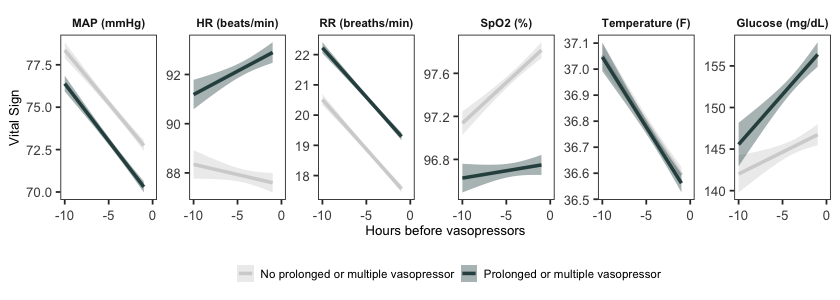

In [154]:
options(repr.plot.width=7, repr.plot.height=2.5)

p <- toplot %>%
    ggplot(aes(x=INTERVAL, y=VALUE, color=FANCY_RESPONSE)) +
        geom_smooth(method=lm, aes(fill=FANCY_RESPONSE)) + 
        xlab("Hours before vasopressors") + ylab("Vital Sign") +
        scale_x_continuous(limits=c(-10,0), breaks=seq(-10,0,5)) +
        base_theme() + 
        scale_color_manual(values=PRESSORHOURS_COLORS)+
        scale_fill_manual(values=PRESSORHOURS_COLORS)+
        theme(legend.title = element_blank()) +
        theme(legend.position="bottom") +
        facet_wrap(. ~ FANCY_VITAL, scale="free", nrow=1)
plot(p)

In [155]:
pdf(file.path(PLOT_DIR, "ancova_vitals.pdf"), 7,2.5)
plot(p)
dev.off()

pdf 
  2

Pressors by type

In [156]:
pressor_choices

[1] "norepinephrinedurations" "dopaminedurations"      
[3] "phenylephrinedurations"  "vasopressindurations"   
[5] "epinephrinedurations"    "dobutaminedurations"

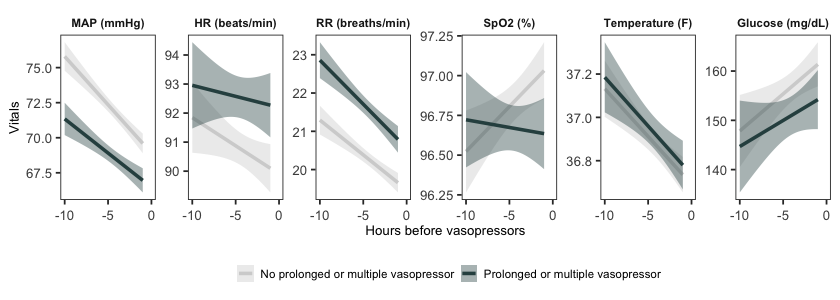

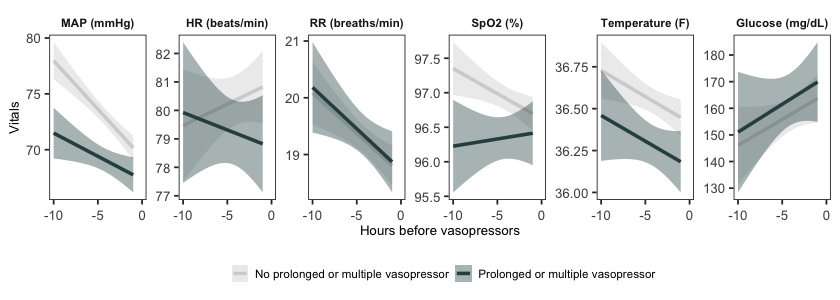

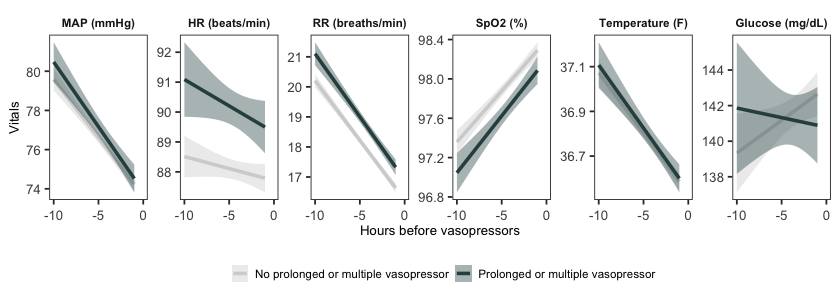

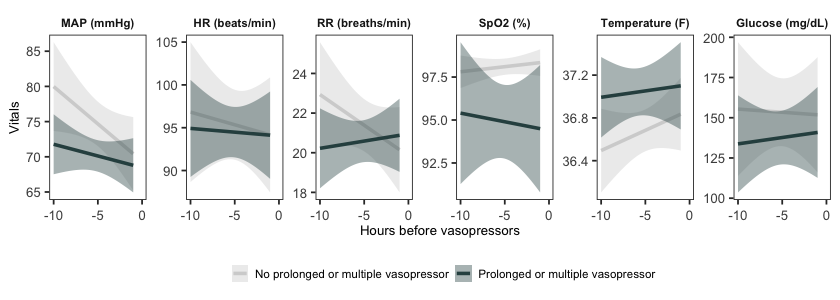

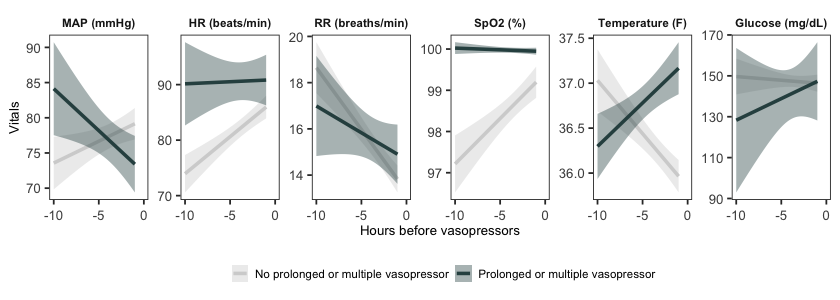

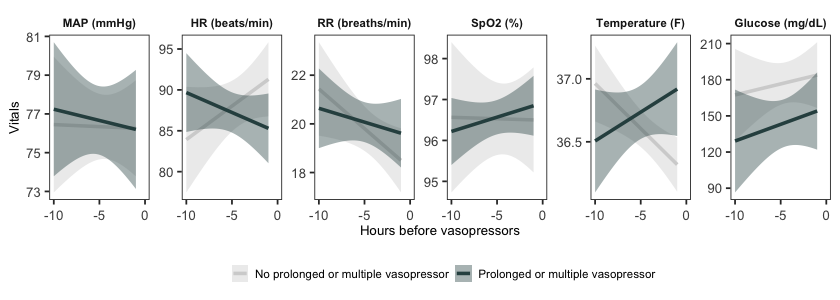

In [157]:
options(repr.plot.width=7, repr.plot.height=2.5)
for(pressor_choice in pressor_choices){
    toplot <- melt_results_df %>%
        filter(!grepl(",", pressor)) %>%
        mutate(INTERVAL = -INTERVAL) %>%
        drop_na(VALUE) %>%
        filter(pressor == pressor_choice, grepl("mean_", ID), ID != "mean_diasbp", ID != "mean_sysbp") %>%
        rowwise() %>%
        mutate(ID = as.character(ID)) %>%
        mutate(FANCY_VITAL = FANCY_VITAL_DICT[ID]) %>%
        mutate(FANCY_VITAL = factor(FANCY_VITAL, levels=FANCY_VITAL_ORDER)) %>%
        mutate(FANCY_RESPONSE = if(RESPONSE){"Prolonged or multiple vasopressor"}else{"No prolonged or multiple vasopressor"})

    p <- ggplot(toplot, aes(x=INTERVAL, y=VALUE, color=FANCY_RESPONSE)) +
        geom_smooth(method=lm, aes(fill=FANCY_RESPONSE)) + 
        xlab("Hours before vasopressors") + ylab("Vitals") +
        scale_x_continuous(limits=c(-10,0), breaks=seq(-10,0,5)) +
        base_theme() + 
        scale_color_manual(values=PRESSORHOURS_COLORS)+
        scale_fill_manual(values=PRESSORHOURS_COLORS)+
        theme(legend.title = element_blank()) +
        theme(legend.position="bottom") +
        facet_wrap(. ~ FANCY_VITAL, scale="free", nrow=1)
    
#     if(pressor_choice == 'phenylephrinedurations'){
#         p <- p + theme(legend.position="bottom")
#     }
    
    plot(p)
    
    pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_ancova_vitals.pdf")), 7,2.5)
    plot(p)
    dev.off()
}

# LR Summary

In [60]:
set.seed(100)

In [61]:
lr_summary_list <- list()

In [136]:
LR_CATEGORICAL_COEFFICIENT_DICT <- c(
'genderM' = "Male Gender",
'intubTRUE' = "Intubated",
'simple_diagnosisINFECTION' = "Infectious Diagnosis",   
'simple_diagnosisSEPSIS' = "Sepsis Diagnosis",
'simple_diagnosisOTHER DIAGNOSIS' = "Other Diagnosis",
'pressorphenylephrinedurations' = 'phenylephrine',
'pressornorepinephrinedurations' = 'norepinephrine',
'first_careunitCSRU' = 'CSRU',
'first_careunitSICU' = 'SICU',
'first_careunitMICU' = 'MICU',
'first_careunitTSICU' = 'TSICU'
)

In [137]:
LR_CONTINUOUS_COEFFICIENT_DICT <- c(
'age_cohort' = 'Age',
'mean_meanbp' = 'MAP',
'mean_resprate' = 'RR',
'mean_heartrate' = 'HR',
'mean_tempc' = 'Temperature',
'mean_spo2' = 'SpO2',
'mean_glucose' = 'Glucose'
)

In [138]:
LR_SEVERITY_COEFFICIENT_DICT <- c(
'qsofa' = 'QSOFA',
'sofa' = 'SOFA',
'oasis' = 'OASIS')

### ROC curve with CI

In [64]:
roc_with_ci <- function(obj) {
  ciobj <- ci.se(obj, specificities = seq(0, 1, l = 25))
  dat.ci <- data.frame(x = as.numeric(rownames(ciobj)),
                       lower = ciobj[, 1],
                       upper = ciobj[, 3])
  
  ggroc(obj) +
    base_theme() +
    theme(axis.title=element_text(size=10)) +
    geom_abline(
      slope = 1,
      intercept = 1,
      linetype = "dashed",
      alpha = 0.7,
      color = '#2F4F4F'
    ) + coord_equal() +
    geom_ribbon(
      data = dat.ci,
      aes(x = x, ymin = lower, ymax = upper),
      fill = '#2F4F4F',
      alpha = 0.2
    ) 
} 

# LR Model for Total
- Ran into problems with missing data for glucose, spo2 and tempc, hence the selection of criteria as variables

In [84]:
model_input_df <- melt_results_df %>%
    filter(INTERVAL == 2) %>%
    select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = ID, COURSE = course_id) %>%
    #mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            select(-pressor) %>%
            select(RESPONSE, course_id, first_careunit, cvc, intub, simple_race, simple_diagnosis, gender, age_cohort, sofa, qsofa, oasis) %>%
            gather(VARIABLE, VALUE, -RESPONSE, -course_id) %>%
            rename(COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE) %>%
    rowwise() %>%
    mutate_at(vars(contains("mean_")), as.numeric, na.rm = TRUE) %>%
    mutate_at(vars(contains("median_")), as.numeric, na.rm = TRUE) %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE,
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
             oasis, qsofa, sofa, 
             contains("mean_meanbp"),
             contains("mean_resprate"),
             contains("mean_heartrate") ,
             contains("mean_tempc"),
             contains("mean_spo2"),
             contains("mean_glucose")
              ) %>%
    mutate(qsofa = as.numeric(qsofa), sofa = as.numeric(sofa), oasis = as.numeric(oasis))

Warning message:
“attributes are not identical across measure variables;
they will be dropped”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

In [85]:
dim(model_input_df) %>% print()

[1] 15136    15


In [86]:
head(model_input_df)

RESPONSE,first_careunit,intub,simple_diagnosis,age_cohort,gender,oasis,qsofa,sofa,mean_meanbp,mean_resprate,mean_heartrate,mean_tempc,mean_spo2,mean_glucose
<lgl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,CSRU,TRUE,CARDIAC,50,M,30,2,3,NA,NA,NA,NA,NA,NA
FALSE,SICU,TRUE,OTHER DIAGNOSIS,70,M,24,0,1,116,28,99,NA,95,NA
FALSE,MICU,TRUE,SEPSIS,80,F,45,2,8,NA,NA,NA,NA,NA,NA
FALSE,CSRU,TRUE,OTHER DIAGNOSIS,70,M,31,2,3,75,27,108,37.55,97,107
FALSE,CSRU,TRUE,CARDIAC,70,F,31,2,3,NA,NA,NA,NA,NA,97
FALSE,MICU,TRUE,INFECTION,60,F,42,2,5,64,29,108,NA,97,NA


In [87]:
# exclude missing cases (done automatically by glm but this allows some more fine control)
model_input_cleaned_df <- model_input_df[which(complete.cases(model_input_df)),]

In [88]:
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_cleaned_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])


all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=learn)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}

p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
#plot(p_out, print.auc=TRUE)

Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


In [89]:
car::vif(model)

,GVIF,Df,GVIF^(1/(2*Df))
first_careunit,2.467652,4,1.119529
intub,1.251640,1,1.118767
simple_diagnosis,1.711064,3,1.093648
age_cohort,1.258736,1,1.121934
gender,1.086791,1,1.042493
oasis,1.768416,1,1.329818
qsofa,1.282051,1,1.132277
sofa,1.486437,1,1.219195
mean_meanbp,1.106603,1,1.051952
mean_resprate,1.506938,1,1.227574


In [90]:
lr_summary_list[['TOTAL']] <- data.frame(MEAN_AUC = mean(aucs), 
                                         SD_AUC = sd(aucs), 
                                         MEAN_ACC = mean(all.acc), 
                                         SD_ACC = sd(all.acc))
lr_summary_list[['TOTAL']] 

MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<dbl>,<dbl>,<dbl>,<dbl>
0.6873293,0.01790236,0.6636934,0.02180376


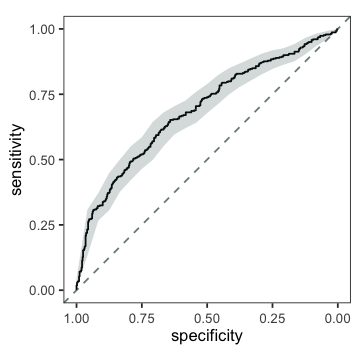

In [92]:
options(repr.plot.width=3, repr.plot.height=3)
p <- roc_with_ci(p_out)

plot(p)

In [93]:
pdf(file.path(PLOT_DIR, paste0("modelauc.pdf")), 3,3)
plot(p)
dev.off()

pdf 
  2

In [94]:
# imputation: 30 mins
model_input_imputed_df <- 
    rfImpute(RESPONSE ~ . , family=binomial(link='logit'), data=model_input_df %>% select(contains("mean"), RESPONSE)) %>%
    cbind(model_input_df %>% select(-contains("mean"), -RESPONSE))

Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2491    99.87 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2507   100.51 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2535   101.60 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2563   102.75 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2559   102.58 |


In [95]:
dim(model_input_df)

[1] 15136    15

In [96]:
dim(model_input_df)

[1] 15136    15

In [97]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_imputed_df)

#### Model parameter significance

In [98]:
summary(model)


Call:
glm(formula = RESPONSE ~ ., family = binomial(link = "logit"), 
    data = model_input_imputed_df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-2.433  -1.060   0.515   1.073   2.213  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -1.1816320  0.2288212  -5.164 2.42e-07 ***
mean_meanbp                     -0.0034721  0.0013971  -2.485  0.01295 *  
mean_resprate                    0.0059347  0.0042270   1.404  0.16032    
mean_heartrate                   0.0029269  0.0012697   2.305  0.02116 *  
mean_tempc                       0.0234675  0.0101013   2.323  0.02017 *  
mean_spo2                       -0.0102375  0.0036306  -2.820  0.00481 ** 
mean_glucose                     0.0012554  0.0004441   2.827  0.00470 ** 
first_careunitCSRU              -0.5296587  0.0608801  -8.700  < 2e-16 ***
first_careunitMICU              -0.2709058  0.0643729  -4.208 2.57e-05 ***
first_careunitSICU       

In [100]:
summary(model)$coefficients %>% data.frame() %>% 
    tibble::rownames_to_column("Variable") %>%
    rename(P.Value = Pr...z..) %>% 
    mutate(SIGNIFICANT = P.Value < 0.05) %>% 
    write.csv(file.path(PLOT_DIR, "modelestimates.csv"))

In [101]:
oddsratio <- exp(cbind(coef(model), confint(model)))  %>% data.frame() 

Waiting for profiling to be done...


In [102]:
oddsratio_categorical <- oddsratio  %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CATEGORICAL_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CATEGORICAL_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CATEGORICAL_COEFFICIENT_DICT)))

oddsratio_categorical %>% write.csv(file.path(PLOT_DIR, "categoricalmodeleodds.csv"))

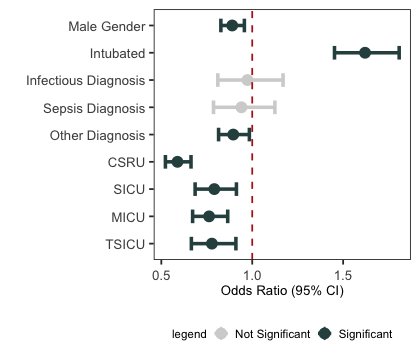

In [106]:
options(repr.plot.width=3.5, repr.plot.height=3)
p <- oddsratio_categorical %>% 
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [130]:
pdf(file.path(PLOT_DIR, paste0("categoricalmodelodds.pdf")), 3.5,3)
plot(p)
dev.off()

pdf 
  2

In [139]:
oddsratio_continuous <-oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CONTINUOUS_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CONTINUOUS_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CONTINUOUS_COEFFICIENT_DICT)))

oddsratio_continuous %>% write.csv(file.path(PLOT_DIR, "continuousmodeleodds.csv"))

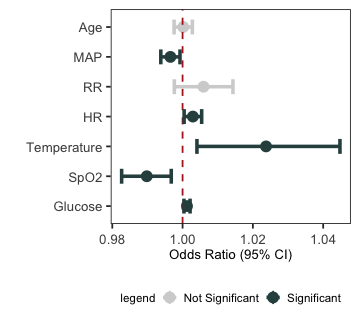

In [141]:
options(repr.plot.width=3, repr.plot.height=2.7)
p <- oddsratio_continuous %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [143]:
oddsratio_severity <-oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_SEVERITY_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_SEVERITY_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_SEVERITY_COEFFICIENT_DICT)))

oddsratio_severity %>% write.csv(file.path(PLOT_DIR, "severitymodeleodds.csv"))

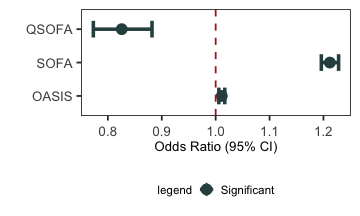

In [147]:
options(repr.plot.width=3, repr.plot.height=1.8)
p <- oddsratio_severity %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [148]:
pdf(file.path(PLOT_DIR, paste0("severitymodelodds.pdf")), 3.1,2.7)
plot(p)
dev.off()

pdf 
  2

# LR Model for norepinephrine
- Running into problems with missing data for glucose, spo2 and tempc. 

In [149]:
pressor_choice <- 'norepinephrinedurations'

In [151]:
model_input_df <- melt_results_df %>%
    filter(grepl(pressor_choice, pressor), INTERVAL == 1) %>% select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = ID, COURSE = course_id) %>%
    #mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            filter(grepl(pressor_choice, pressor))  %>%
            select(-pressor) %>%
            select(RESPONSE, course_id, first_careunit, cvc, intub, simple_race, simple_diagnosis, gender, age_cohort, qsofa, sofa, oasis) %>%
            gather(VARIABLE, VALUE, -RESPONSE, -course_id) %>%
            rename(COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE) %>%
    mutate_at(vars(contains("mean_")), as.numeric, na.rm = TRUE) %>%
    mutate_at(vars(contains("median_")), as.numeric, na.rm = TRUE) %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE, 
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
           qsofa, sofa, oasis,
              contains("mean_meanbp"),
             contains("mean_resprate"),
             contains("mean_heartrate"),
             contains("mean_tempc"),
             contains("mean_spo2"),
             contains("mean_glucose")
              ) %>%
    mutate(qsofa = as.numeric(qsofa), sofa = as.numeric(sofa), oasis = as.numeric(oasis))

Warning message:
“attributes are not identical across measure variables;
they will be dropped”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

In [152]:
dim(model_input_df) %>% print()

[1] 6173   15


In [153]:
# exclude missing cases (done automatically by glm but this allows some more fine control)
model_input_cleaned_df <- model_input_df[which(complete.cases(model_input_df)),]

In [154]:
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_cleaned_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])


all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=learn)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}

p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
#plot(p_out, print.auc=TRUE)

Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


In [155]:
car::vif(model) %>% print()

                     GVIF Df GVIF^(1/(2*Df))
first_careunit   2.185699  4        1.102678
intub            1.478035  1        1.215744
simple_diagnosis 1.779444  3        1.100814
age_cohort       1.166188  1        1.079902
gender           1.140931  1        1.068144
qsofa            1.272419  1        1.128016
sofa             1.426499  1        1.194361
oasis            1.779162  1        1.333852
mean_meanbp      1.166118  1        1.079870
mean_resprate    1.487441  1        1.219607
mean_heartrate   1.180420  1        1.086471
mean_tempc       1.208541  1        1.099336
mean_spo2        1.211722  1        1.100783
mean_glucose     1.089992  1        1.044027


In [156]:
lr_summary_list[[pressor_choice]] <- data.frame(MEAN_AUC = mean(aucs), 
                                         SD_AUC = sd(aucs), 
                                         MEAN_ACC = mean(all.acc), 
                                         SD_ACC = sd(all.acc))
lr_summary_list[[pressor_choice]] 

MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<dbl>,<dbl>,<dbl>,<dbl>
0.7066267,0.08283818,0.7729625,0.02616663


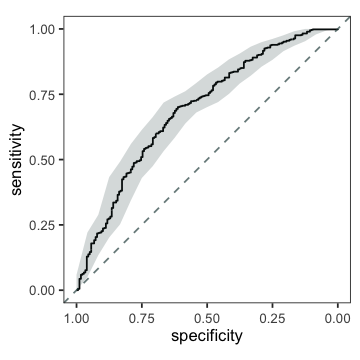

In [157]:
options(repr.plot.width=3, repr.plot.height=3)
p <- roc_with_ci(p_out)

plot(p)

In [158]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_modelauc.pdf")), 3,3)
plot(p)
dev.off()

pdf 
  2

In [162]:
# imputation: 30 mins
model_input_imputed_df <- 
    rfImpute(RESPONSE ~ . , family=binomial(link='logit'), data=model_input_df %>% select(contains("mean"), RESPONSE)) %>%
    cbind(model_input_df %>% select(-contains("mean"), -RESPONSE))

Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.1977   101.50 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.1968   101.02 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.1987   102.02 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.1995   102.42 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2006   102.99 |


In [163]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_imputed_df)

In [164]:
summary(model) %>% print()


Call:
glm(formula = RESPONSE ~ ., family = binomial(link = "logit"), 
    data = model_input_imputed_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5308  -0.9512   0.5882   0.7739   1.8007  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      4.8602655  1.6615796   2.925 0.003444 ** 
mean_meanbp                     -0.0093841  0.0021866  -4.292 1.77e-05 ***
mean_resprate                    0.0052701  0.0066551   0.792 0.428427    
mean_heartrate                   0.0132426  0.0019392   6.829 8.55e-12 ***
mean_tempc                      -0.0638729  0.0380495  -1.679 0.093214 .  
mean_spo2                       -0.0312695  0.0083752  -3.734 0.000189 ***
mean_glucose                    -0.0007293  0.0005890  -1.238 0.215634    
first_careunitCSRU               0.0019980  0.1281374   0.016 0.987559    
first_careunitMICU              -0.5108213  0.1060793  -4.815 1.47e-06 ***
first_careunitS

In [165]:
# isolate out model coefficients
summary(model)$coefficients %>% data.frame() %>% 
    tibble::rownames_to_column("Variable") %>%
    rename(P.Value = Pr...z..) %>% 
    mutate(SIGNIFICANT = P.Value < 0.05) %>% 
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_modelestimates.csv")))

In [166]:
oddsratio <- exp(cbind(coef(model), confint(model)))

Waiting for profiling to be done...


In [167]:
oddsratio_categorical <- oddsratio  %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CATEGORICAL_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CATEGORICAL_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CATEGORICAL_COEFFICIENT_DICT)))

oddsratio_categorical %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodeleodds.csv")))

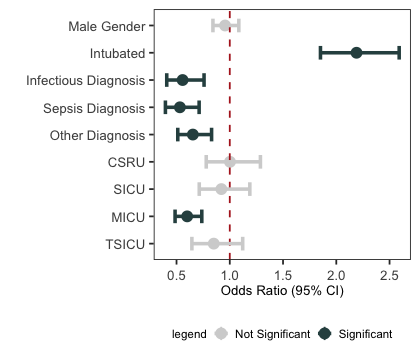

In [168]:
options(repr.plot.width=3.5, repr.plot.height=3)
p <- oddsratio_categorical %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [169]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodelodds.pdf")), 3.5,3)
plot(p)
dev.off()

pdf 
  2

In [170]:
oddsratio_continuous <- oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CONTINUOUS_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CONTINUOUS_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CONTINUOUS_COEFFICIENT_DICT)))

oddsratio_continuous %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodeleodds.csv")))

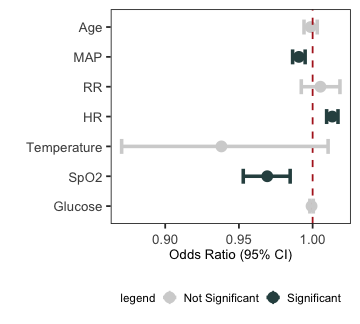

In [171]:
options(repr.plot.width=3, repr.plot.height=2.7)
p <- oddsratio_continuous %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [172]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodelodds.pdf")), 3.1,2.7)
plot(p)
dev.off()

pdf 
  2

In [173]:
oddsratio_severity <-oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_SEVERITY_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_SEVERITY_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_SEVERITY_COEFFICIENT_DICT)))

oddsratio_severity %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_severitymodelodds.csv")))

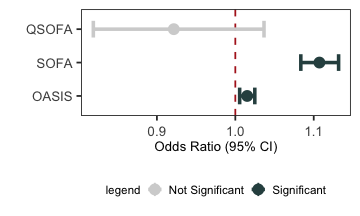

In [174]:
options(repr.plot.width=3, repr.plot.height=1.8)
p <- oddsratio_severity %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [175]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_severitymodelodds.pdf")), 3.1,2.7)
plot(p)
dev.off()

pdf 
  2

# LR Model for dopamine
- Running into problems with missing data for glucose, spo2 and tempc. 

In [176]:
pressor_choice <- 'dopaminedurations'

In [178]:
model_input_df <- melt_results_df %>%
    filter(grepl(pressor_choice, pressor), INTERVAL == 1) %>% select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = ID, COURSE = course_id) %>%
    #mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            filter(grepl(pressor_choice, pressor))  %>%
            select(-pressor) %>%
            select(RESPONSE, course_id, first_careunit, cvc, intub, simple_race, simple_diagnosis, gender, age_cohort, qsofa, sofa, oasis) %>%
            gather(VARIABLE, VALUE, -RESPONSE, -course_id) %>%
            rename(COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE) %>%
    mutate_at(vars(contains("mean_")), as.numeric, na.rm = TRUE) %>%
    mutate_at(vars(contains("median_")), as.numeric, na.rm = TRUE) %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE, 
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
           qsofa, sofa, oasis,
              contains("mean_meanbp"),
             contains("mean_resprate"),
             contains("mean_heartrate"),
             contains("mean_tempc"),
             contains("mean_spo2"),
             contains("mean_glucose")
              ) %>%
    mutate(qsofa = as.numeric(qsofa), sofa = as.numeric(sofa), oasis = as.numeric(oasis))

Warning message:
“attributes are not identical across measure variables;
they will be dropped”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

In [179]:
dim(model_input_df) %>% print()

[1] 2689   15


In [180]:
# exclude missing cases (done automatically by glm but this allows some more fine control)
model_input_cleaned_df <- model_input_df[which(complete.cases(model_input_df)),]

In [181]:
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_cleaned_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])


all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=learn)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}

p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
#plot(p_out, print.auc=TRUE)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


In [182]:
car::vif(model) %>% print()

                     GVIF Df GVIF^(1/(2*Df))
first_careunit   2.526934  4        1.122856
intub            1.863363  1        1.365051
simple_diagnosis 1.291599  3        1.043569
age_cohort       1.273958  1        1.128698
gender           1.213440  1        1.101562
qsofa            1.274173  1        1.128793
sofa             1.722602  1        1.312479
oasis            2.028516  1        1.424260
mean_meanbp      1.161511  1        1.077734
mean_resprate    1.365044  1        1.168351
mean_heartrate   1.280869  1        1.131755
mean_tempc       1.166638  1        1.080110
mean_spo2        1.160487  1        1.077259
mean_glucose     1.311902  1        1.145383


In [183]:
lr_summary_list[[pressor_choice]] <- data.frame(MEAN_AUC = mean(aucs), 
                                         SD_AUC = sd(aucs), 
                                         MEAN_ACC = mean(all.acc), 
                                         SD_ACC = sd(all.acc))
lr_summary_list[[pressor_choice]] 

MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<dbl>,<dbl>,<dbl>,<dbl>
0.7496761,0.1309041,0.8368116,0.08172423


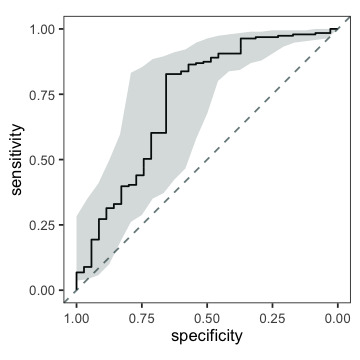

In [184]:
options(repr.plot.width=3, repr.plot.height=3)
p <- roc_with_ci(p_out)

plot(p)

In [185]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_modelauc.pdf")), 3,3)
plot(p)
dev.off()

pdf 
  2

In [198]:
# imputation: 30 mins
model_input_imputed_df <- 
    rfImpute(RESPONSE ~ . , family=binomial(link='logit'), data=model_input_df %>% select(contains("mean"), RESPONSE)) %>%
    cbind(model_input_df %>% select(-contains("mean"), -RESPONSE))

Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2123   101.23 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2111   100.64 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2111   100.65 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2123   101.21 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |    0.212   101.05 |


In [199]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_imputed_df)

In [200]:
summary(model) %>% print()


Call:
glm(formula = RESPONSE ~ ., family = binomial(link = "logit"), 
    data = model_input_imputed_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6141  -0.8670   0.5100   0.7764   1.9484  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      2.8559232  2.8495170   1.002  0.31622    
mean_meanbp                     -0.0112055  0.0036764  -3.048  0.00230 ** 
mean_resprate                    0.0136350  0.0114051   1.196  0.23189    
mean_heartrate                   0.0147905  0.0031319   4.723 2.33e-06 ***
mean_tempc                      -0.1247225  0.0695373  -1.794  0.07288 .  
mean_spo2                       -0.0060955  0.0110163  -0.553  0.58004    
mean_glucose                    -0.0004514  0.0008663  -0.521  0.60232    
first_careunitCSRU               0.8784027  0.1928629   4.555 5.25e-06 ***
first_careunitMICU               0.0921684  0.1199455   0.768  0.44224    
first_careunitS

In [201]:
# isolate out model coefficients
summary(model)$coefficients %>% data.frame() %>% 
    tibble::rownames_to_column("Variable") %>%
    rename(P.Value = Pr...z..) %>% 
    mutate(SIGNIFICANT = P.Value < 0.05) %>% 
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_modelestimates.csv")))

In [202]:
oddsratio <- exp(cbind(coef(model), confint(model)))

Waiting for profiling to be done...


In [203]:
oddsratio_categorical <- oddsratio %>% data.frame()  %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CATEGORICAL_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CATEGORICAL_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CATEGORICAL_COEFFICIENT_DICT)))

oddsratio_categorical %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodeleodds.csv")))

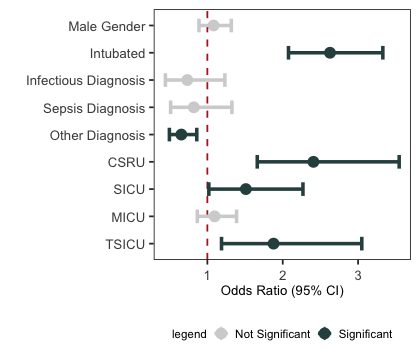

In [204]:
options(repr.plot.width=3.5, repr.plot.height=3)
p <- oddsratio_categorical %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [205]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodelodds.pdf")), 3.5,3)
plot(p)
dev.off()

pdf 
  2

In [206]:
oddsratio_continuous <-oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CONTINUOUS_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CONTINUOUS_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CONTINUOUS_COEFFICIENT_DICT)))

oddsratio_continuous %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodeleodds.csv")))

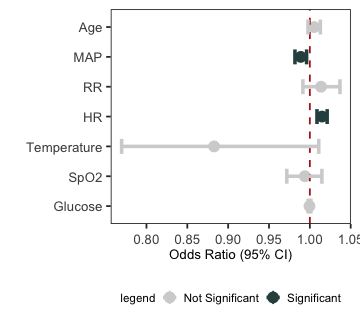

In [207]:
options(repr.plot.width=3, repr.plot.height=2.7)
p <- oddsratio_continuous %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [208]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodelodds.pdf")), 3.1,2.7)
plot(p)
dev.off()

pdf 
  2

In [209]:
oddsratio_severity <-oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_SEVERITY_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_SEVERITY_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_SEVERITY_COEFFICIENT_DICT)))

oddsratio_severity %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_severitymodelodds.csv")))

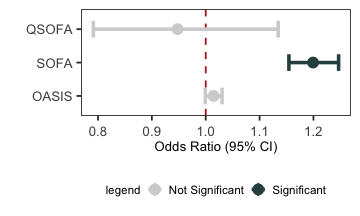

In [210]:
options(repr.plot.width=3, repr.plot.height=1.8)
p <- oddsratio_severity %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [211]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_severitymodelodds.pdf")), 3.1,2.7)
plot(p)
dev.off()

pdf 
  2

# LR Model for phenylephrine
- Running into problems with missing data for glucose, spo2 and tempc. 

In [212]:
pressor_choice <- 'phenylephrinedurations'

In [213]:
model_input_df <- melt_results_df %>%
    filter(grepl(pressor_choice, pressor), INTERVAL == 1) %>% select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = ID, COURSE = course_id) %>%
    #mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            filter(grepl(pressor_choice, pressor))  %>%
            select(-pressor) %>%
            select(RESPONSE, course_id, first_careunit, cvc, intub, simple_race, simple_diagnosis, gender, age_cohort, qsofa, sofa, oasis) %>%
            gather(VARIABLE, VALUE, -RESPONSE, -course_id) %>%
            rename(COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE) %>%
    mutate_at(vars(contains("mean_")), as.numeric, na.rm = TRUE) %>%
    mutate_at(vars(contains("median_")), as.numeric, na.rm = TRUE) %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE, 
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
           qsofa, sofa, oasis,
              contains("mean_meanbp"),
             contains("mean_resprate"),
             contains("mean_heartrate"),
             contains("mean_tempc"),
             contains("mean_spo2"),
             contains("mean_glucose")
              ) %>%
    mutate(qsofa = as.numeric(qsofa), sofa = as.numeric(sofa), oasis = as.numeric(oasis))

Warning message:
“attributes are not identical across measure variables;
they will be dropped”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

In [214]:
dim(model_input_df) %>% print()

[1] 9503   15


In [215]:
# exclude missing cases (done automatically by glm but this allows some more fine control)
model_input_cleaned_df <- model_input_df[which(complete.cases(model_input_df)),]

In [216]:
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_cleaned_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])


all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=learn)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}

p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
#plot(p_out, print.auc=TRUE)

Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


In [217]:
car::vif(model) %>% print()

                     GVIF Df GVIF^(1/(2*Df))
first_careunit   1.838698  4        1.079105
intub            1.162678  1        1.078276
simple_diagnosis 1.298041  3        1.044435
age_cohort       1.189303  1        1.090552
gender           1.051494  1        1.025424
qsofa            1.269107  1        1.126546
sofa             1.392147  1        1.179893
oasis            1.558900  1        1.248559
mean_meanbp      1.126881  1        1.061547
mean_resprate    1.384566  1        1.176676
mean_heartrate   1.277874  1        1.130431
mean_tempc       1.235089  1        1.111345
mean_spo2        1.181990  1        1.087194
mean_glucose     1.092676  1        1.045311


In [218]:
lr_summary_list[[pressor_choice]] <- data.frame(MEAN_AUC = mean(aucs), 
                                         SD_AUC = sd(aucs), 
                                         MEAN_ACC = mean(all.acc), 
                                         SD_ACC = sd(all.acc))
lr_summary_list[[pressor_choice]] 

MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<dbl>,<dbl>,<dbl>,<dbl>
0.7212573,0.03059543,0.6730542,0.02151379


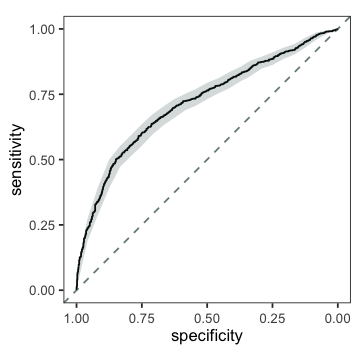

In [219]:
options(repr.plot.width=3, repr.plot.height=3)
p <- roc_with_ci(p_out)

plot(p)

In [220]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_modelauc.pdf")), 3,3)
plot(p)
dev.off()

pdf 
  2

In [221]:
# imputation: 30 mins
model_input_imputed_df <- 
    rfImpute(RESPONSE ~ . , family=binomial(link='logit'), data=model_input_df %>% select(contains("mean"), RESPONSE)) %>%
    cbind(model_input_df %>% select(-contains("mean"), -RESPONSE))

Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2456    98.60 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |    0.245    98.34 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2459    98.71 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2482    99.64 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2479    99.50 |


In [222]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_imputed_df)

In [223]:
summary(model) %>% print()


Call:
glm(formula = RESPONSE ~ ., family = binomial(link = "logit"), 
    data = model_input_imputed_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7662  -1.0036   0.3075   1.0238   1.9810  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      3.3650865  1.4983898   2.246 0.024717 *  
mean_meanbp                     -0.0010822  0.0019366  -0.559 0.576282    
mean_resprate                    0.0081328  0.0055625   1.462 0.143720    
mean_heartrate                   0.0067220  0.0016554   4.061 4.89e-05 ***
mean_tempc                      -0.0791427  0.0325926  -2.428 0.015172 *  
mean_spo2                       -0.0155188  0.0082758  -1.875 0.060764 .  
mean_glucose                     0.0014910  0.0006531   2.283 0.022428 *  
first_careunitCSRU              -0.9540646  0.0913398 -10.445  < 2e-16 ***
first_careunitMICU              -0.3397976  0.1095804  -3.101 0.001929 ** 
first_careunitS

In [224]:
# isolate out model coefficients
summary(model)$coefficients %>% data.frame() %>% 
    tibble::rownames_to_column("Variable") %>%
    rename(P.Value = Pr...z..) %>% 
    mutate(SIGNIFICANT = P.Value < 0.05) %>% 
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_modelestimates.csv")))

In [225]:
oddsratio <- exp(cbind(coef(model), confint(model)))

Waiting for profiling to be done...


In [226]:
oddsratio_categorical <- oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CATEGORICAL_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CATEGORICAL_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CATEGORICAL_COEFFICIENT_DICT)))

oddsratio_categorical %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodeleodds.csv")))

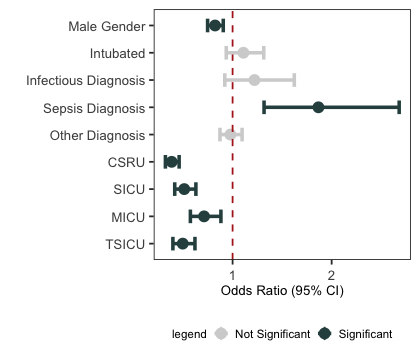

In [227]:
options(repr.plot.width=3.5, repr.plot.height=3)
p <- oddsratio_categorical %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [228]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodelodds.pdf")), 3.5,3)
plot(p)
dev.off()

pdf 
  2

In [229]:
oddsratio_continuous <-oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CONTINUOUS_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CONTINUOUS_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CONTINUOUS_COEFFICIENT_DICT)))

oddsratio_continuous %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodeleodds.csv")))

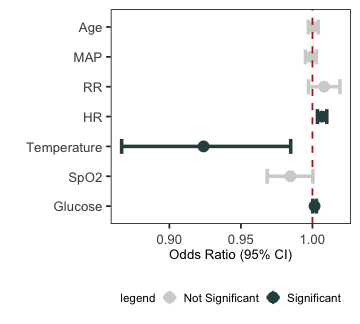

In [230]:
options(repr.plot.width=3, repr.plot.height=2.7)
p <- oddsratio_continuous %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [231]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodelodds.pdf")), 3.1,2.7)
plot(p)
dev.off()

pdf 
  2

In [232]:
oddsratio_severity <-oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_SEVERITY_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_SEVERITY_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_SEVERITY_COEFFICIENT_DICT)))

oddsratio_severity %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_severitymodelodds.csv")))

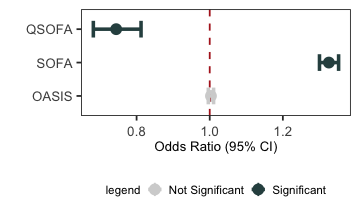

In [233]:
options(repr.plot.width=3, repr.plot.height=1.8)
p <- oddsratio_severity %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [234]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_severitymodelodds.pdf")), 3.1,2.7)
plot(p)
dev.off()

pdf 
  2

# Output AUC table

In [235]:
auc_output_df <- bind_rows(lr_summary_list, .id="PRESSOR")
auc_output_df 

PRESSOR,MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
TOTAL,0.6873293,0.01790236,0.6636934,0.02180376
norepinephrinedurations,0.7066267,0.08283818,0.7729625,0.02616663
dopaminedurations,0.7496761,0.13090405,0.8368116,0.08172423
phenylephrinedurations,0.7212573,0.03059543,0.6730542,0.02151379


In [236]:
auc_output_df  %>% write.csv(file.path(PLOT_DIR, "summary_auc.csv"))